In [ ]:
from google.colab import drive
drive.mount("/content/drive", force_remount=True)

Mounted at /content/drive


In [ ]:
%cd drive/MyDrive

/content/drive/MyDrive


In [ ]:
%cd Image Denoising

/content/drive/MyDrive/Image Denoising


In [ ]:
%cd MWCNN

/content/drive/MyDrive/Image Denoising/MWCNN


In [ ]:

%matplotlib inline
import warnings
warnings.filterwarnings("ignore")

import os
import pathlib
from matplotlib import pyplot as plt
import seaborn as sns
import pickle
import pandas as pd
import numpy as np
import cv2
import skimage
from skimage.util import random_noise
import tensorflow as tf

from tqdm.notebook import tqdm
import random

In [ ]:
def get_images_paths(root_dir):
    # Getting dataset images
    root = pathlib.Path(root_dir)
    img_paths = list(root.rglob("*.png*"))
    img_paths_lst = [str(path) for path in img_paths]

    gt_lst = []
    noisy_lst= []
    for p in img_paths_lst:
        img_type = p.split("/")[-1].split('.')[0]
        if img_type=='199':
          continue
        noisy_lst.append(p)
    for o in img_paths_lst:
        img_type = o.split("/")[-1].split('.')[0]
        gt_lst.append(o)
    # print(gt_lst)
    gt_lst1 = []
    for i in gt_lst:
      img_type = i.split("/")[-1].split('.')[0]
      if img_type=='199':
        gt_lst1.append(i)

    gt_lst1 = (len(gt_lst)-1)*gt_lst1

    noisy_array = np.asarray(noisy_lst)
    gt_array = np.asarray(gt_lst1)
    return noisy_array, gt_array

In [ ]:
noisy_train_paths, gt_train_paths = get_images_paths("exp1/images/train")
noisy_test_paths, gt_test_paths = get_images_paths("exp1/images/test")

In [ ]:
print(noisy_train_paths.shape)
print(noisy_test_paths.shape)
print(gt_train_paths.shape)
print(gt_test_paths.shape)

(50,)
(12,)
(50,)
(12,)


In [ ]:
# Get gt_images in memory
def get_images_in_mem(images_paths):
    images_lst = []
    for img_path in tqdm(images_paths):
        img = cv2.imread(img_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        img = cv2.resize(img, (128, 128))
        images_lst.append(img)
    return np.array(images_lst)

In [ ]:
noisy_train_images = get_images_in_mem(noisy_train_paths)
noisy_test_images = get_images_in_mem(noisy_test_paths)

gt_train_images = get_images_in_mem(gt_train_paths)
gt_test_images = get_images_in_mem(gt_test_paths)

print(noisy_train_images.shape)
print(noisy_test_images.shape)

print(gt_train_images.shape)
print(gt_test_images.shape)

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

(50, 128, 128, 3)
(12, 128, 128, 3)
(50, 128, 128, 3)
(12, 128, 128, 3)


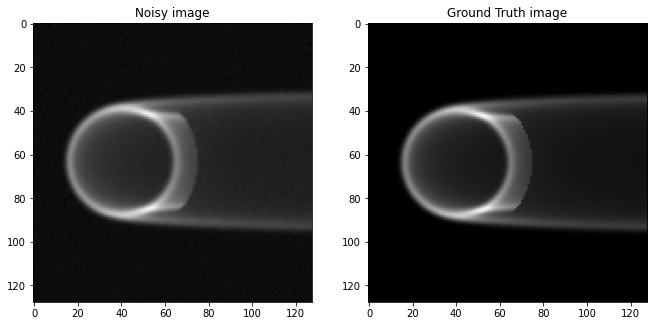

In [ ]:
f, axarr = plt.subplots(1,2, figsize=(11,11))
axarr[0].imshow(noisy_train_images[30])
axarr[0].set_title("Noisy image")
axarr[1].imshow(gt_train_images[30])
axarr[1].title.set_text("Ground Truth image")

In [ ]:
def tf_data_generator(X, y, batch_size=32):
    dataset = tf.data.Dataset.from_tensor_slices((X, y)) # This is the main step for data generation
    dataset = dataset.shuffle(1000, reshuffle_each_iteration=True)

    dataset = dataset.repeat()
    dataset = dataset.batch(batch_size=batch_size, drop_remainder=True)
    dataset = dataset.prefetch(tf.data.experimental.AUTOTUNE)
    return dataset

BATCH_SIZE=4

image_generator_train = tf_data_generator(X=noisy_train_images, y=gt_train_images, batch_size=BATCH_SIZE)
image_generator_test = tf_data_generator(X=noisy_test_images, y=gt_test_images, batch_size=BATCH_SIZE)

NameError: ignored

In [ ]:
image_generator_train

<PrefetchDataset element_spec=(TensorSpec(shape=(4, 128, 128, 3), dtype=tf.uint8, name=None), TensorSpec(shape=(4, 128, 128, 3), dtype=tf.uint8, name=None))>

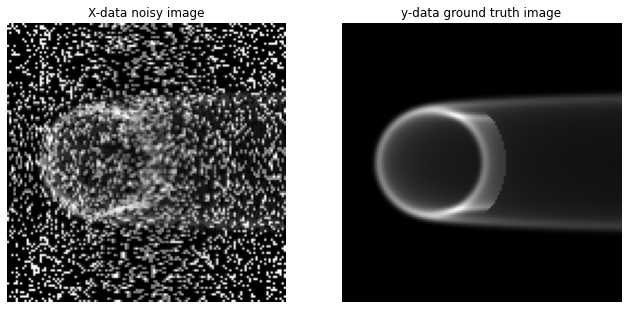

In [ ]:
# SANITY CHECK of the Dataset generator
for noisy, gt in image_generator_train.take(1):  # only take first element of dataset
    numpy_images = noisy.numpy()
    numpy_labels = gt.numpy()

f, axarr = plt.subplots(1,2, figsize=(11,11))
axarr[0].imshow(numpy_images[1])
axarr[0].set_title("X-data noisy image")
axarr[0].set_axis_off()

axarr[1].imshow(numpy_labels[1])
axarr[1].set_title("y-data ground truth image")
axarr[1].set_axis_off()

In [ ]:
import tensorflow as tf
from tensorflow.keras import models, layers
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Conv2D, Conv2DTranspose,\
                                    GlobalAveragePooling2D, AveragePooling2D, MaxPool2D, UpSampling2D,\
                                    BatchNormalization, Activation, ReLU, Flatten, Dense, Input,\
                                    Add, Multiply, Concatenate, Softmax
from tensorflow.keras import initializers, regularizers
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.activations import softmax

tf.keras.backend.set_image_data_format('channels_last')
import keras.backend as K

In [ ]:
class Conv_block(tf.keras.layers.Layer):
    def  __init__(self, num_filters=200, kernel_size=3, **kwargs):
        super().__init__(**kwargs)
        self.num_filters=num_filters
        self.kernel_size=kernel_size
        self.conv_1 = Conv2D(filters=self.num_filters, kernel_size=self.kernel_size, padding='same')
        self.conv_2 = Conv2D(filters=self.num_filters, kernel_size=self.kernel_size, padding='same')
        self.conv_3 = Conv2D(filters=self.num_filters, kernel_size=self.kernel_size, padding='same')
        self.conv_4 = Conv2D(filters=self.num_filters, kernel_size=self.kernel_size, padding='same')

        self.bn_1 = BatchNormalization()
        self.bn_2 = BatchNormalization()
        self.bn_3 = BatchNormalization()
        self.bn_4 = BatchNormalization()

    def get_config(self):
        config = super().get_config().copy()
        config.update({
            'num_filters': self.num_filters,
            'kernel_size':self.kernel_size
        })
        return config

    def call(self, X):
        X = self.conv_1(X)
        # X = self.bn_1(X)
        X = ReLU()(X)
        X = self.conv_2(X)
        # X = self.bn_2(X)
        X = ReLU()(X)
        X = self.conv_3(X)
        # X = self.bn_3(X)
        X = ReLU()(X)
        # X = self.conv_4(X)
        # # X = self.bn_4(X)
        # X = ReLU()(X)

        return X

In [ ]:
class DWT_downsampling(tf.keras.layers.Layer):
    def __init__(self, **kwargs):
        super().__init__(**kwargs)

    def call(self, x):
        """
        The following calculations for DWT are inspired from,
        https://github.com/AureliePeng/Keras-WaveletTransform/blob/master/models/DWT.py
        """
        x1 = x[:, 0::2, 0::2, :] #x(2i−1, 2j−1)
        x2 = x[:, 1::2, 0::2, :] #x(2i, 2j-1)
        x3 = x[:, 0::2, 1::2, :] #x(2i−1, 2j)
        x4 = x[:, 1::2, 1::2, :] #x(2i, 2j)

        x_LL = x1 + x2 + x3 + x4
        x_LH = -x1 - x3 + x2 + x4
        x_HL = -x1 + x3 - x2 + x4
        x_HH = x1 - x3 - x2 + x4

        return Concatenate(axis=-1)([x_LL, x_LH, x_HL, x_HH])

In [ ]:
class IWT_upsampling(tf.keras.layers.Layer):
    def __init__(self, **kwargs):
        super().__init__(**kwargs)

    def call(self, x):
        """
        The following calculations for IWT are inspired from,
        https://github.com/AureliePeng/Keras-WaveletTransform/blob/master/models/DWT.py
        """
        x_LL = x[:, :, :, 0:x.shape[3]//4]
        x_LH = x[:, :, :, x.shape[3]//4:x.shape[3]//4*2]
        x_HL = x[:, :, :, x.shape[3]//4*2:x.shape[3]//4*3]
        x_HH = x[:, :, :, x.shape[3]//4*3:]

        x1 = (x_LL - x_LH - x_HL + x_HH)/4
        x2 = (x_LL - x_LH + x_HL - x_HH)/4
        x3 = (x_LL + x_LH - x_HL - x_HH)/4
        x4 = (x_LL + x_LH + x_HL + x_HH)/4

        y1 = K.stack([x1,x3], axis=2)
        y2 = K.stack([x2,x4], axis=2)
        shape = K.shape(x)
        return K.reshape(K.concatenate([y1,y2], axis=-1), K.stack([shape[0], shape[1]*2, shape[2]*2, shape[3]//4]))

In [ ]:
def create_model():
    tf.keras.backend.clear_session()

    input = Input(shape=(128,128,3))

    cb_1 = Conv_block(num_filters=64)(input)
    dwt_1 = DWT_downsampling()(cb_1)

    cb_2 = Conv_block(num_filters=128)(dwt_1)
    dwt_2 = DWT_downsampling()(cb_2)

    cb_3 = Conv_block(num_filters=256)(dwt_2)
    dwt_3 = DWT_downsampling()(cb_3)

    cb_4 = Conv_block(num_filters=512)(dwt_3)
    dwt_4 = DWT_downsampling()(cb_4)

    cb_5 = Conv_block(num_filters=512)(dwt_4)
    cb_5 = BatchNormalization()(cb_5)
    cb_5 = Conv_block(num_filters=512)(cb_5)
    cb_5 = Conv2D(filters=2048, kernel_size=3, strides=1, padding='same')(cb_5)

    up = IWT_upsampling()(cb_5)
    up = Conv_block(num_filters=512)(Add()([up, cb_4]))
    up = Conv2D(filters=1024, kernel_size=3, strides=1, padding='same')(up)

    up = IWT_upsampling()(up)
    up = Conv_block(num_filters=256)(Add()([up, cb_3]))
    up = Conv2D(filters=512, kernel_size=3, strides=1, padding='same')(up)

    up = IWT_upsampling()(up)
    up = Conv_block(num_filters=128)(Add()([up, cb_2]))
    up = Conv2D(filters=256, kernel_size=3, strides=1, padding='same')(up)

    up = IWT_upsampling()(up)
    up = Conv_block(num_filters=64)(Add()([up, cb_1]))
    up = Conv2D(filters=128, kernel_size=3, strides=1, padding='same')(up)

    out = Conv2D(filters=3, kernel_size=(1, 1), padding="same")(up)

    return Model(inputs=[input], outputs=[out])

model = create_model()
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 128, 128, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv_block (Conv_block)        (None, 128, 128, 64  75648       ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 dwt_downsampling (DWT_downsamp  (None, 64, 64, 256)  0          ['conv_block[0][0]']             
 ling)                                                                                        

In [ ]:
# steps_per_epoch_train = len(noisy_train_images)
# steps_per_epoch_validation = len(noisy_test_images)

In [ ]:
# callbacks_lst = [
#     tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', min_lr=0.0000009, min_delta=0.0001, factor=0.70, patience=3, verbose=1, mode='min'),
#     tf.keras.callbacks.EarlyStopping(monitor='val_loss', mode='min', verbose=1, min_delta=0.0001, patience=10)
# ]

In [ ]:
# model.compile(loss=tf.keras.losses.MeanSquaredError(), optimizer=Adam(learning_rate=0.0009))
# model.fit(image_generator_train,
#           validation_data=image_generator_test,
#                         steps_per_epoch=steps_per_epoch_train,
#                         validation_steps=steps_per_epoch_validation,
#                         epochs=100,
#                         verbose=1,
#                         callbacks=callbacks_lst)

Epoch 1/100
50/50 [==============================] - 28s 190ms/step - loss: 13044.1572 - val_loss: 948.8843 - lr: 9.0000e-04
Epoch 2/100
50/50 [==============================] - 8s 155ms/step - loss: 506.9863 - val_loss: 208.2494 - lr: 9.0000e-04
Epoch 3/100
50/50 [==============================] - 8s 159ms/step - loss: 179.2964 - val_loss: 176.9966 - lr: 9.0000e-04
Epoch 4/100
50/50 [==============================] - 8s 158ms/step - loss: 152.2632 - val_loss: 210.3440 - lr: 9.0000e-04
Epoch 5/100
50/50 [==============================] - 8s 158ms/step - loss: 149.8467 - val_loss: 180.3064 - lr: 9.0000e-04
Epoch 6/100
50/50 [==============================] - 8s 159ms/step - loss: 137.4388 - val_loss: 127.0100 - lr: 9.0000e-04
Epoch 7/100
50/50 [==============================] - 8s 160ms/step - loss: 118.1293 - val_loss: 115.8845 - lr: 9.0000e-04
Epoch 8/100
50/50 [==============================] - 8s 163ms/step - loss: 86.5925 - val_loss: 80.2276 - lr: 9.0000e-04
Epoch 9/100
50/50 [====

In [ ]:
# best_models_path = "./"
# model.save(best_models_path+"MWCNN_exp1_100epoch.h5")

In [ ]:
# best_models_path = "./"
# model = tf.keras.models.load_model(best_models_path+'MWCNN_exp1_100epoch.h5', custom_objects={'DWT_downsampling':DWT_downsampling,
#                                                                                                         'IWT_upsampling':IWT_upsampling,
#                                                                                                         'Conv_block':Conv_block})

In [ ]:
# Inference
def inference_single_image(model, noisy_image):
    input_image = np.expand_dims(noisy_image, axis=0)
    predicted_image = model.predict(input_image)

    return predicted_image[0]

def inference_batch_images(model, noisy_images):
    predicted_image = model.predict(noisy_images)
    return predicted_image

In [ ]:
def visualize_predictions(model, X_test, y_test, n):
    random_numbers = random.choices(range(X_test.shape[0]), k=n)    # Get n random indices
    for i in random_numbers:
        noisy_image = X_test[i]
        gt_image = y_test[i]
        predicted_image = inference_single_image(model, X_test[i])
        predicted_image/=255

        f, axarr = plt.subplots(1,3, figsize=(10,10))
        axarr[0].imshow(noisy_image)
        axarr[0].set_title("Noisy image")
        axarr[0].set_axis_off()
        axarr[1].imshow(gt_image)
        axarr[1].set_title("Ground truth image")
        axarr[1].set_axis_off()
        axarr[2].imshow(predicted_image)
        axarr[2].set_title("Predicted image")
        axarr[2].set_axis_off()



Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

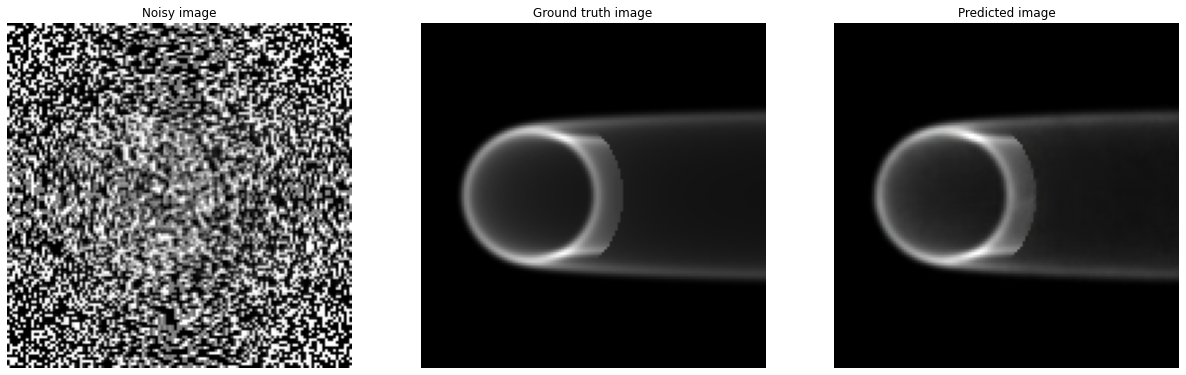

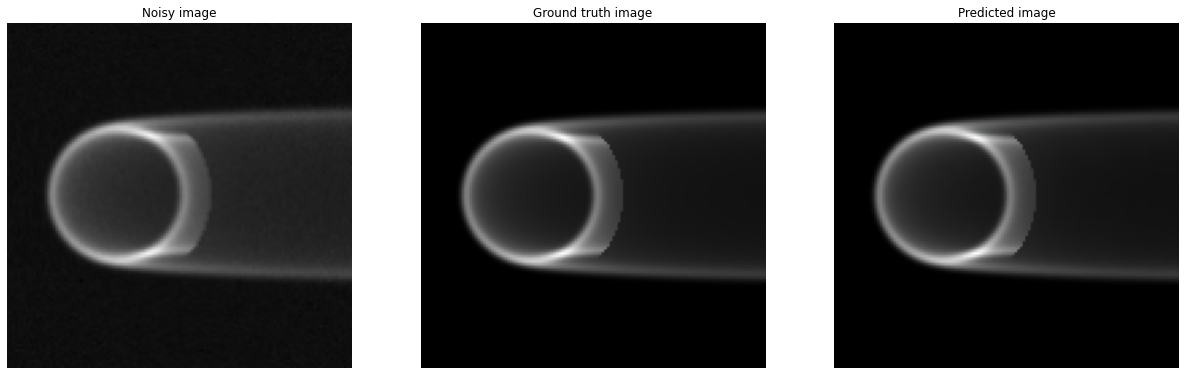

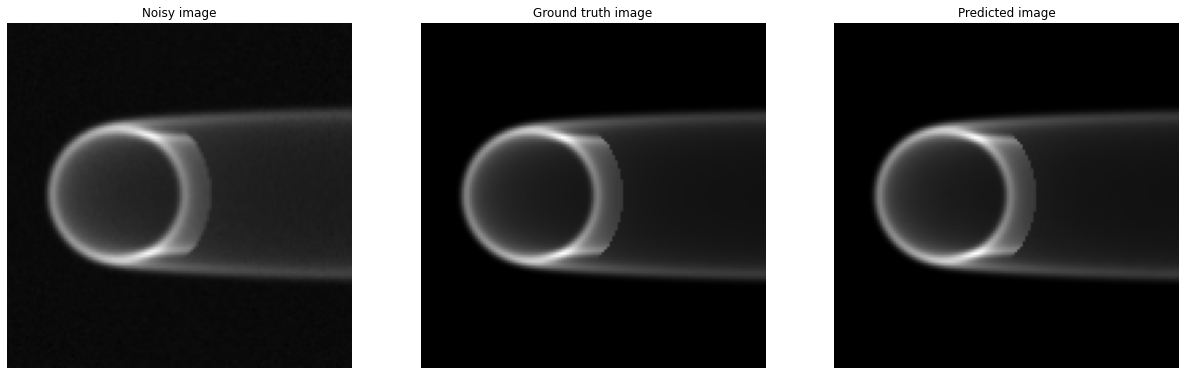

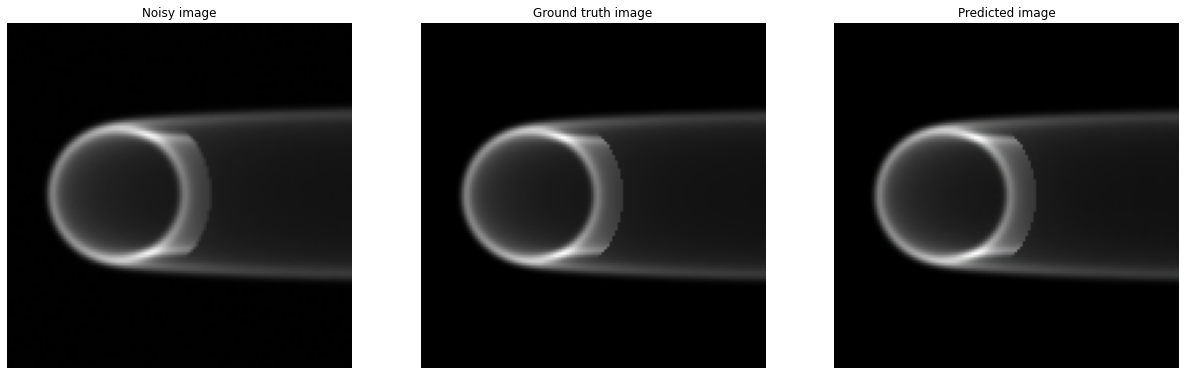

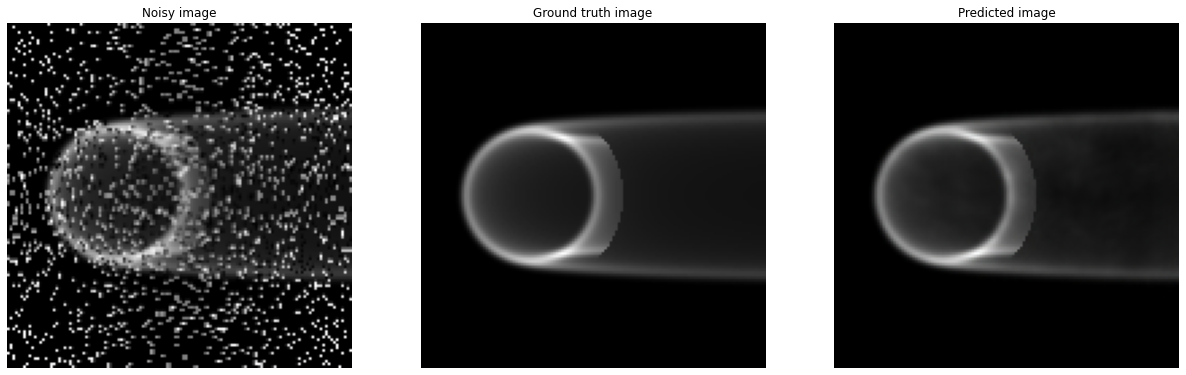

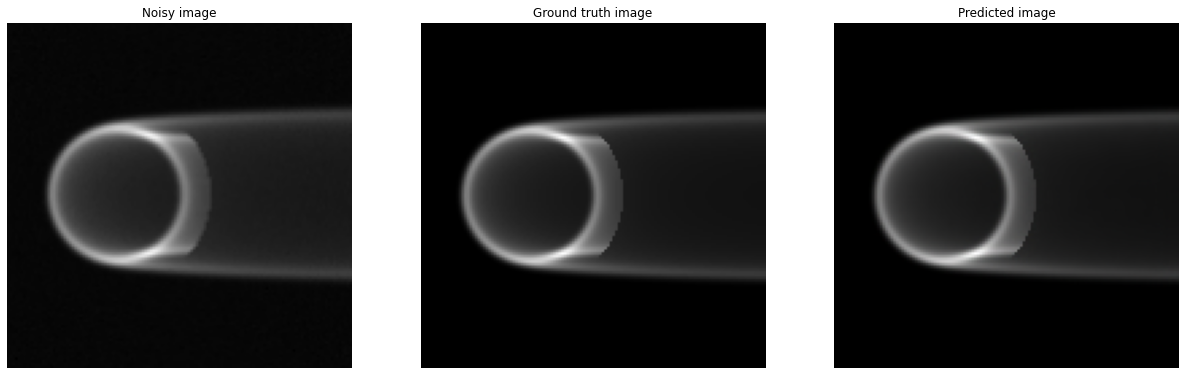

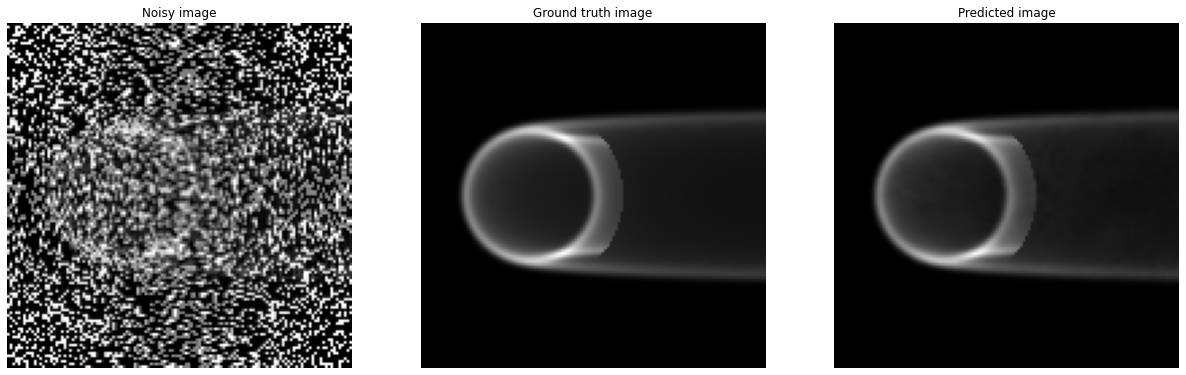

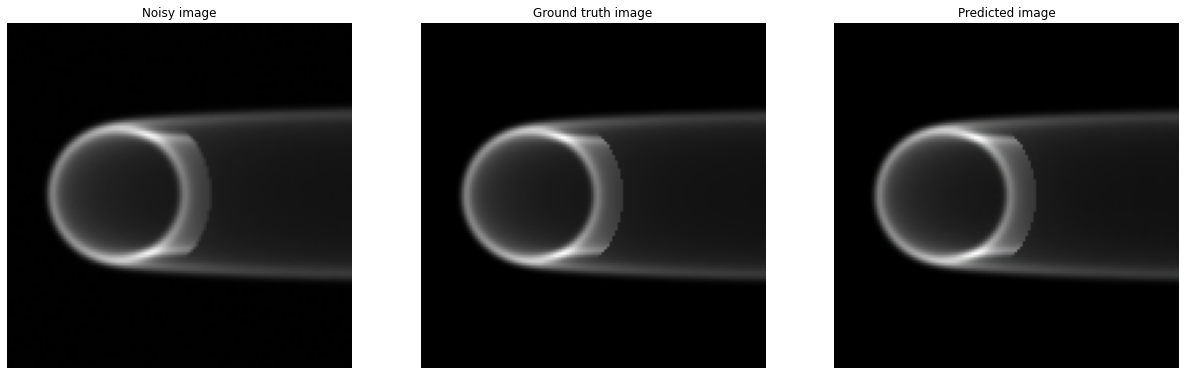

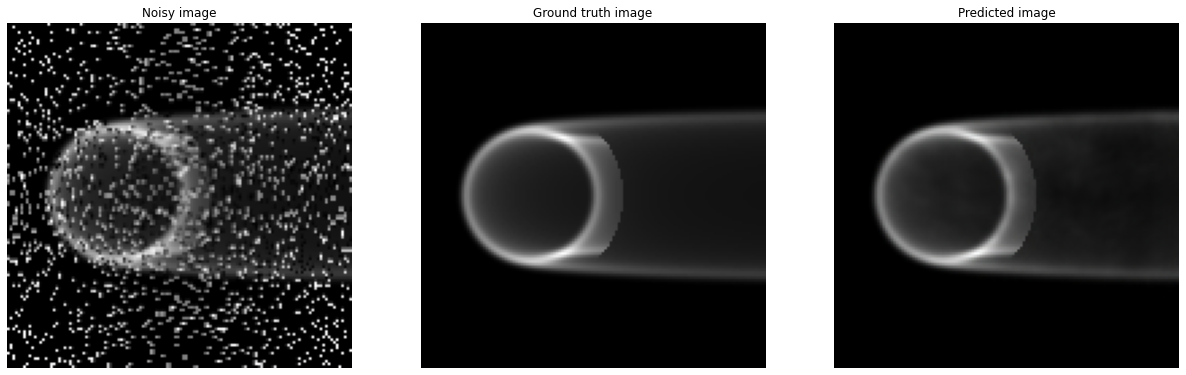

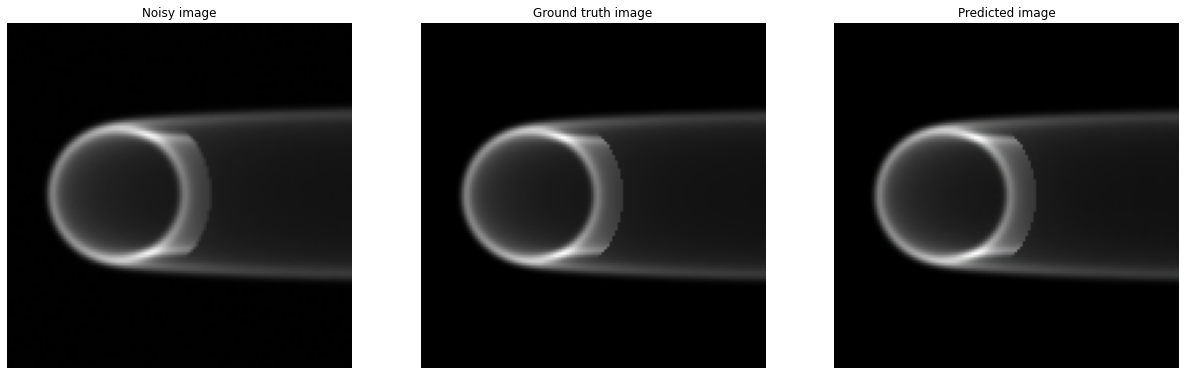

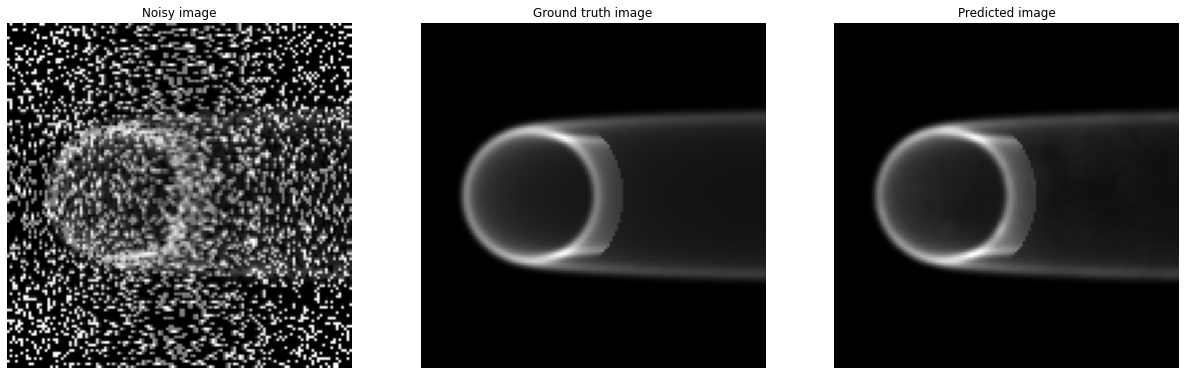

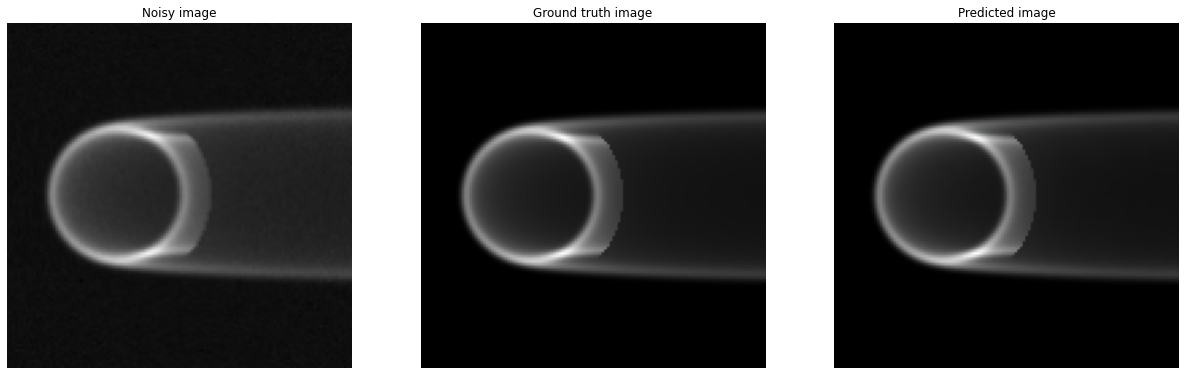

In [ ]:
visualize_predictions(model, noisy_test_images, gt_test_images, 12)

In [ ]:
from skimage.metrics import peak_signal_noise_ratio

predicted_images = inference_batch_images(model, noisy_test_images)
psnr_original_mean = 0
psnr_prediction_mean = 0

for gt_img, noisy_img, predicted_img in zip(gt_test_images, noisy_test_images, predicted_images):
    psnr_original_mean += peak_signal_noise_ratio(gt_img, noisy_img)
    psnr_prediction_mean += peak_signal_noise_ratio(gt_img, predicted_img)

psnr_original_mean/=gt_test_images.shape[0]
psnr_prediction_mean/=gt_test_images.shape[0]
print("Original average gt-noisy PSNR ->", psnr_original_mean)
print("Predicted average gt-predicted PSNR ->", psnr_prediction_mean)

In [ ]:
from skimage.metrics import structural_similarity as ssim

predicted_images = inference_batch_images(model, noisy_test_images)
ssim_original_mean = 0
ssim_prediction_mean = 0

for gt_img, noisy_img, predicted_img in zip(gt_test_images, noisy_test_images, predicted_images):
    ssim_original_mean += ssim(gt_img, noisy_img, multichannel=True, data_range=noisy_img.max() - noisy_img.min())
    ssim_prediction_mean += ssim(gt_img, predicted_img, multichannel=True, data_range=predicted_img.max() - predicted_img.min())

ssim_original_mean/=gt_test_images.shape[0]
ssim_prediction_mean/=gt_test_images.shape[0]
print("Original average gt-noisy SSIM ->", ssim_original_mean)
print("Predicted average gt-predicted SSIM ->", ssim_prediction_mean)

Original average gt-noisy SSIM -> 0.3956737301791891
Predicted average gt-predicted SSIM -> 0.996700298617549


**g10**

In [ ]:
noisy_test_paths1, gt_test_paths1 = get_images_paths("g10")

In [ ]:
print(noisy_test_paths1.shape)
print(gt_test_paths1.shape)

(1,)
(1,)


In [ ]:
noisy_test_images1 = get_images_in_mem(noisy_test_paths1)
gt_test_images1 = get_images_in_mem(gt_test_paths1)

print(noisy_test_images1.shape)
print(gt_test_images1.shape)

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

(1, 128, 128, 3)
(1, 128, 128, 3)


In [ ]:
best_models_path = "./"
model1 = tf.keras.models.load_model(best_models_path+'MWCNN_exp1_100epoch.h5', custom_objects={'DWT_downsampling':DWT_downsampling,
                                                                                                        'IWT_upsampling':IWT_upsampling,
                                                                                                        'Conv_block':Conv_block})

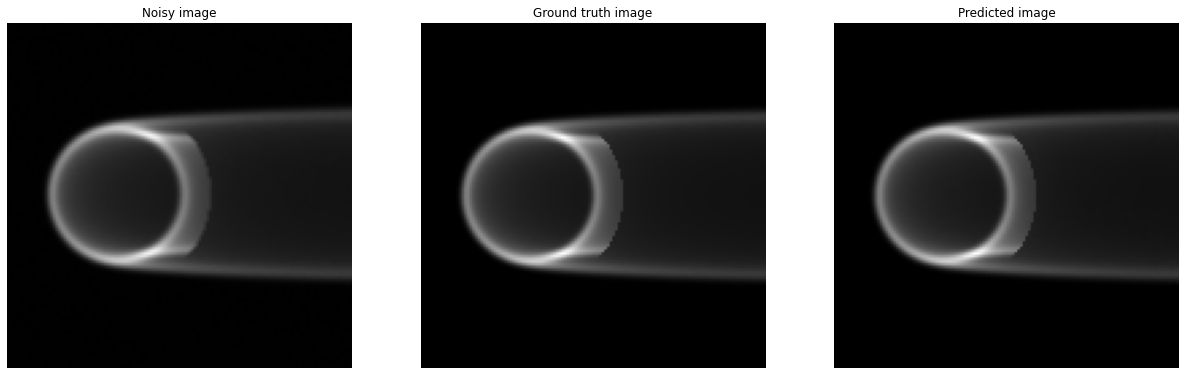

In [ ]:
visualize_predictions(model1, noisy_test_images1, gt_test_images1, 1)

In [ ]:
from skimage.metrics import peak_signal_noise_ratio

predicted_images = inference_batch_images(model1, noisy_test_images1)
psnr_original_mean = 0
psnr_prediction_mean = 0

for gt_img, noisy_img, predicted_img in zip(gt_test_images1, noisy_test_images1, predicted_images):
    psnr_original_mean += peak_signal_noise_ratio(gt_img, noisy_img)
    psnr_prediction_mean += peak_signal_noise_ratio(gt_img, predicted_img)

psnr_original_mean/=gt_test_images1.shape[0]
psnr_prediction_mean/=gt_test_images1.shape[0]
print("Original average gt-noisy PSNR ->", psnr_original_mean)
print("Predicted average gt-predicted PSNR ->", psnr_prediction_mean)

Original average gt-noisy PSNR -> 32.645023211992765
Predicted average gt-predicted PSNR -> 56.5308431973603


In [ ]:
from skimage.metrics import structural_similarity as ssim

predicted_images = inference_batch_images(model1, noisy_test_images1)
ssim_original_mean = 0
ssim_prediction_mean = 0

for gt_img, noisy_img, predicted_img in zip(gt_test_images1, noisy_test_images1, predicted_images):
    ssim_original_mean += ssim(gt_img, noisy_img, multichannel=True, data_range=noisy_img.max() - noisy_img.min())
    ssim_prediction_mean += ssim(gt_img, predicted_img, multichannel=True, data_range=predicted_img.max() - predicted_img.min())

ssim_original_mean/=gt_test_images1.shape[0]
ssim_prediction_mean/=gt_test_images1.shape[0]
print("Original average gt-noisy SSIM ->", ssim_original_mean)
print("Predicted average gt-predicted SSIM ->", ssim_prediction_mean)

Original average gt-noisy SSIM -> 0.9005081142956931
Predicted average gt-predicted SSIM -> 0.9990348589448926


g20

In [ ]:
noisy_test_paths1, gt_test_paths1 = get_images_paths("g20")

In [ ]:
print(noisy_test_paths1.shape)
print(gt_test_paths1.shape)

(1,)
(1,)


In [ ]:
noisy_test_images1 = get_images_in_mem(noisy_test_paths1)
gt_test_images1 = get_images_in_mem(gt_test_paths1)

print(noisy_test_images1.shape)
print(gt_test_images1.shape)

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

(1, 128, 128, 3)
(1, 128, 128, 3)


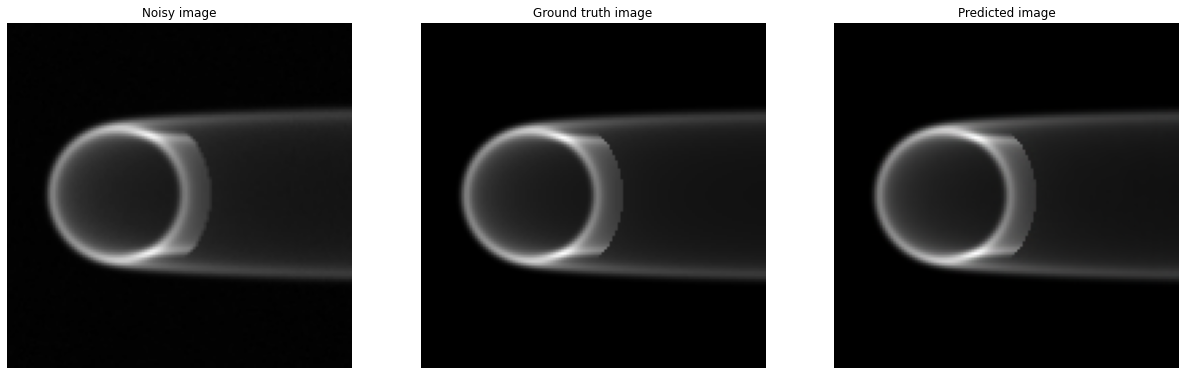

In [ ]:
visualize_predictions(model1, noisy_test_images1, gt_test_images1, 1)

In [ ]:
from skimage.metrics import peak_signal_noise_ratio

predicted_images = inference_batch_images(model1, noisy_test_images1)
psnr_original_mean = 0
psnr_prediction_mean = 0

for gt_img, noisy_img, predicted_img in zip(gt_test_images1, noisy_test_images1, predicted_images):
    psnr_original_mean += peak_signal_noise_ratio(gt_img, noisy_img)
    psnr_prediction_mean += peak_signal_noise_ratio(gt_img, predicted_img)

psnr_original_mean/=gt_test_images1.shape[0]
psnr_prediction_mean/=gt_test_images1.shape[0]
print("Original average gt-noisy PSNR ->", psnr_original_mean)
print("Predicted average gt-predicted PSNR ->", psnr_prediction_mean)

Original average gt-noisy PSNR -> 31.992104203085635
Predicted average gt-predicted PSNR -> 56.53939883281229


In [ ]:
from skimage.metrics import structural_similarity as ssim

predicted_images = inference_batch_images(model1, noisy_test_images1)
ssim_original_mean = 0
ssim_prediction_mean = 0

for gt_img, noisy_img, predicted_img in zip(gt_test_images1, noisy_test_images1, predicted_images):
    ssim_original_mean += ssim(gt_img, noisy_img, multichannel=True, data_range=noisy_img.max() - noisy_img.min())
    ssim_prediction_mean += ssim(gt_img, predicted_img, multichannel=True, data_range=predicted_img.max() - predicted_img.min())

ssim_original_mean/=gt_test_images1.shape[0]
ssim_prediction_mean/=gt_test_images1.shape[0]
print("Original average gt-noisy SSIM ->", ssim_original_mean)
print("Predicted average gt-predicted SSIM ->", ssim_prediction_mean)

Original average gt-noisy SSIM -> 0.7176870617721635
Predicted average gt-predicted SSIM -> 0.9991076850476458


g30


In [ ]:
noisy_test_paths1, gt_test_paths1 = get_images_paths("g30")

In [ ]:
print(noisy_test_paths1.shape)
print(gt_test_paths1.shape)

(1,)
(1,)


In [ ]:
noisy_test_images1 = get_images_in_mem(noisy_test_paths1)
gt_test_images1 = get_images_in_mem(gt_test_paths1)

print(noisy_test_images1.shape)
print(gt_test_images1.shape)

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

(1, 128, 128, 3)
(1, 128, 128, 3)


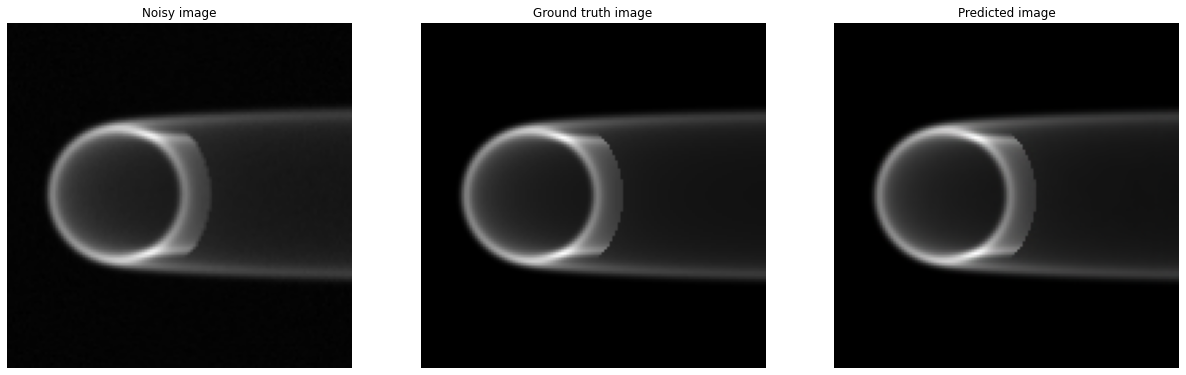

In [ ]:
visualize_predictions(model1, noisy_test_images1, gt_test_images1, 1)

In [ ]:
from skimage.metrics import peak_signal_noise_ratio

predicted_images = inference_batch_images(model1, noisy_test_images1)
psnr_original_mean = 0
psnr_prediction_mean = 0

for gt_img, noisy_img, predicted_img in zip(gt_test_images1, noisy_test_images1, predicted_images):
    psnr_original_mean += peak_signal_noise_ratio(gt_img, noisy_img)
    psnr_prediction_mean += peak_signal_noise_ratio(gt_img, predicted_img)

psnr_original_mean/=gt_test_images1.shape[0]
psnr_prediction_mean/=gt_test_images1.shape[0]
print("Original average gt-noisy PSNR ->", psnr_original_mean)
print("Predicted average gt-predicted PSNR ->", psnr_prediction_mean)

Original average gt-noisy PSNR -> 31.049839972771302
Predicted average gt-predicted PSNR -> 56.919788144822064


In [ ]:
from skimage.metrics import structural_similarity as ssim

predicted_images = inference_batch_images(model1, noisy_test_images1)
ssim_original_mean = 0
ssim_prediction_mean = 0

for gt_img, noisy_img, predicted_img in zip(gt_test_images1, noisy_test_images1, predicted_images):
    ssim_original_mean += ssim(gt_img, noisy_img, multichannel=True, data_range=noisy_img.max() - noisy_img.min())
    ssim_prediction_mean += ssim(gt_img, predicted_img, multichannel=True, data_range=predicted_img.max() - predicted_img.min())

ssim_original_mean/=gt_test_images1.shape[0]
ssim_prediction_mean/=gt_test_images1.shape[0]
print("Original average gt-noisy SSIM ->", ssim_original_mean)
print("Predicted average gt-predicted SSIM ->", ssim_prediction_mean)

Original average gt-noisy SSIM -> 0.5896912298909927
Predicted average gt-predicted SSIM -> 0.9991266704088017


g40

In [ ]:
noisy_test_paths1, gt_test_paths1 = get_images_paths("../g40")

In [ ]:
print(noisy_test_paths1.shape)
print(gt_test_paths1.shape)

(10,)
(10,)


In [ ]:
noisy_test_images1 = get_images_in_mem(noisy_test_paths1)
gt_test_images1 = get_images_in_mem(gt_test_paths1)

print(noisy_test_images1.shape)
print(gt_test_images1.shape)

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

(10, 128, 128, 3)
(10, 128, 128, 3)


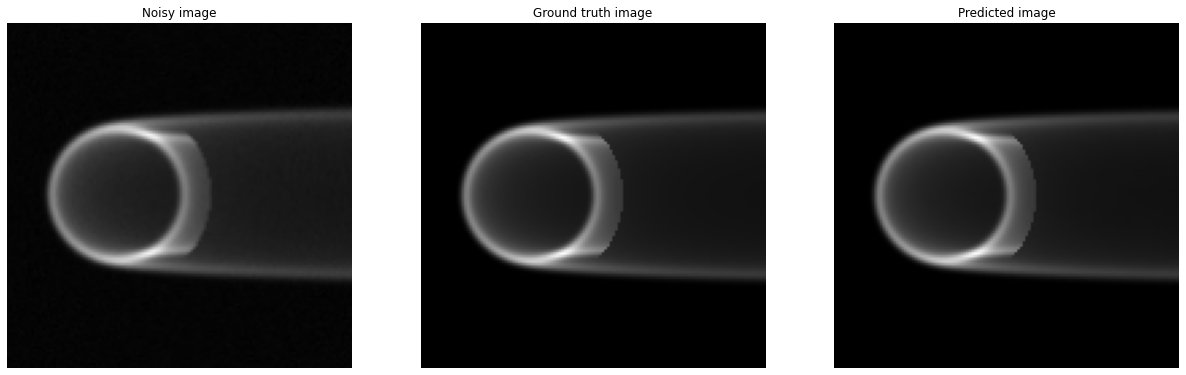

In [ ]:
visualize_predictions(model1, noisy_test_images1, gt_test_images1, 1)

In [ ]:
from skimage.metrics import peak_signal_noise_ratio

predicted_images = inference_batch_images(model1, noisy_test_images1)
psnr_original_mean = 0
psnr_prediction_mean = 0

for gt_img, noisy_img, predicted_img in zip(gt_test_images1, noisy_test_images1, predicted_images):
    psnr_original_mean += peak_signal_noise_ratio(gt_img, noisy_img)
    psnr_prediction_mean += peak_signal_noise_ratio(gt_img, predicted_img)

psnr_original_mean/=gt_test_images1.shape[0]
psnr_prediction_mean/=gt_test_images1.shape[0]
print("Original average gt-noisy PSNR ->", psnr_original_mean)
print("Predicted average gt-predicted PSNR ->", psnr_prediction_mean)

Original average gt-noisy PSNR -> 30.252170859925645
Predicted average gt-predicted PSNR -> 55.88675667546214


In [ ]:
from skimage.metrics import structural_similarity as ssim

predicted_images = inference_batch_images(model1, noisy_test_images1)
ssim_original_mean = 0
ssim_prediction_mean = 0

for gt_img, noisy_img, predicted_img in zip(gt_test_images1, noisy_test_images1, predicted_images):
    ssim_original_mean += ssim(gt_img, noisy_img, multichannel=True, data_range=noisy_img.max() - noisy_img.min())
    ssim_prediction_mean += ssim(gt_img, predicted_img, multichannel=True, data_range=predicted_img.max() - predicted_img.min())

ssim_original_mean/=gt_test_images1.shape[0]
ssim_prediction_mean/=gt_test_images1.shape[0]
print("Original average gt-noisy SSIM ->", ssim_original_mean)
print("Predicted average gt-predicted SSIM ->", ssim_prediction_mean)

Original average gt-noisy SSIM -> 0.54507345496411
Predicted average gt-predicted SSIM -> 0.9991211327249687


g50

In [ ]:
noisy_test_paths1, gt_test_paths1 = get_images_paths("g50")

In [ ]:
print(noisy_test_paths1.shape)
print(gt_test_paths1.shape)

(1,)
(1,)


In [ ]:
noisy_test_images1 = get_images_in_mem(noisy_test_paths1)
gt_test_images1 = get_images_in_mem(gt_test_paths1)

print(noisy_test_images1.shape)
print(gt_test_images1.shape)

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

(1, 128, 128, 3)
(1, 128, 128, 3)


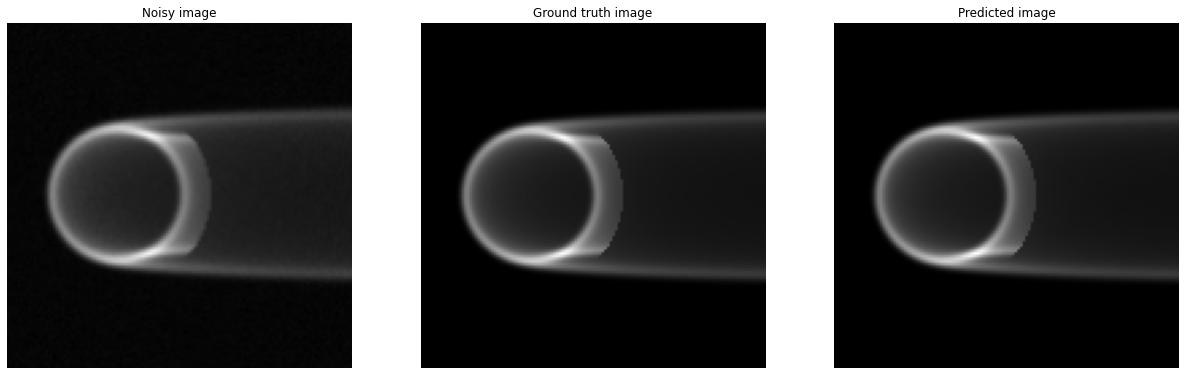

In [ ]:
visualize_predictions(model1, noisy_test_images1, gt_test_images1, 1)

In [ ]:
from skimage.metrics import peak_signal_noise_ratio

predicted_images = inference_batch_images(model1, noisy_test_images1)
psnr_original_mean = 0
psnr_prediction_mean = 0

for gt_img, noisy_img, predicted_img in zip(gt_test_images1, noisy_test_images1, predicted_images):
    psnr_original_mean += peak_signal_noise_ratio(gt_img, noisy_img)
    psnr_prediction_mean += peak_signal_noise_ratio(gt_img, predicted_img)

psnr_original_mean/=gt_test_images1.shape[0]
psnr_prediction_mean/=gt_test_images1.shape[0]
print("Original average gt-noisy PSNR ->", psnr_original_mean)
print("Predicted average gt-predicted PSNR ->", psnr_prediction_mean)

Original average gt-noisy PSNR -> 29.837137606252888
Predicted average gt-predicted PSNR -> 56.2822651789752


In [ ]:
from skimage.metrics import structural_similarity as ssim

predicted_images = inference_batch_images(model1, noisy_test_images1)
ssim_original_mean = 0
ssim_prediction_mean = 0

for gt_img, noisy_img, predicted_img in zip(gt_test_images1, noisy_test_images1, predicted_images):
    ssim_original_mean += ssim(gt_img, noisy_img, multichannel=True, data_range=noisy_img.max() - noisy_img.min())
    ssim_prediction_mean += ssim(gt_img, predicted_img, multichannel=True, data_range=predicted_img.max() - predicted_img.min())

ssim_original_mean/=gt_test_images1.shape[0]
ssim_prediction_mean/=gt_test_images1.shape[0]
print("Original average gt-noisy SSIM ->", ssim_original_mean)
print("Predicted average gt-predicted SSIM ->", ssim_prediction_mean)

Original average gt-noisy SSIM -> 0.5215898614612334
Predicted average gt-predicted SSIM -> 0.999103454145069


g60

In [ ]:
noisy_test_paths1, gt_test_paths1 = get_images_paths("g60")

In [ ]:
print(noisy_test_paths1.shape)
print(gt_test_paths1.shape)

(1,)
(1,)


In [ ]:
noisy_test_images1 = get_images_in_mem(noisy_test_paths1)
gt_test_images1 = get_images_in_mem(gt_test_paths1)

print(noisy_test_images1.shape)
print(gt_test_images1.shape)

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

(1, 128, 128, 3)
(1, 128, 128, 3)


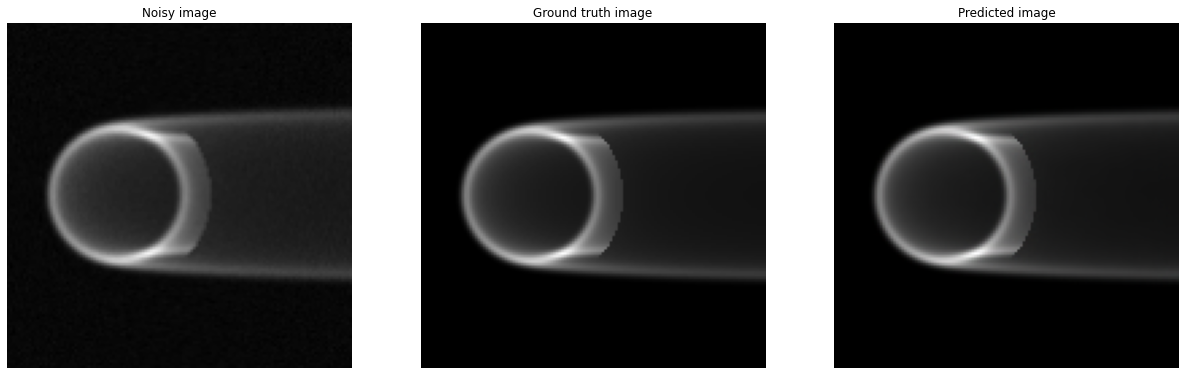

In [ ]:
visualize_predictions(model1, noisy_test_images1, gt_test_images1, 1)

In [ ]:
from skimage.metrics import peak_signal_noise_ratio

predicted_images = inference_batch_images(model1, noisy_test_images1)
psnr_original_mean = 0
psnr_prediction_mean = 0

for gt_img, noisy_img, predicted_img in zip(gt_test_images1, noisy_test_images1, predicted_images):
    psnr_original_mean += peak_signal_noise_ratio(gt_img, noisy_img)
    psnr_prediction_mean += peak_signal_noise_ratio(gt_img, predicted_img)

psnr_original_mean/=gt_test_images1.shape[0]
psnr_prediction_mean/=gt_test_images1.shape[0]
print("Original average gt-noisy PSNR ->", psnr_original_mean)
print("Predicted average gt-predicted PSNR ->", psnr_prediction_mean)

Original average gt-noisy PSNR -> 28.450140321394425
Predicted average gt-predicted PSNR -> 53.40794903835643


In [ ]:
from skimage.metrics import structural_similarity as ssim

predicted_images = inference_batch_images(model1, noisy_test_images1)
ssim_original_mean = 0
ssim_prediction_mean = 0

for gt_img, noisy_img, predicted_img in zip(gt_test_images1, noisy_test_images1, predicted_images):
    ssim_original_mean += ssim(gt_img, noisy_img, multichannel=True, data_range=noisy_img.max() - noisy_img.min())
    ssim_prediction_mean += ssim(gt_img, predicted_img, multichannel=True, data_range=predicted_img.max() - predicted_img.min())

ssim_original_mean/=gt_test_images1.shape[0]
ssim_prediction_mean/=gt_test_images1.shape[0]
print("Original average gt-noisy SSIM ->", ssim_original_mean)
print("Predicted average gt-predicted SSIM ->", ssim_prediction_mean)

Original average gt-noisy SSIM -> 0.48455871975101233
Predicted average gt-predicted SSIM -> 0.9990339182673108


g70


In [ ]:
noisy_test_paths1, gt_test_paths1 = get_images_paths("g70")

In [ ]:
print(noisy_test_paths1.shape)
print(gt_test_paths1.shape)

(1,)
(1,)


In [ ]:
noisy_test_images1 = get_images_in_mem(noisy_test_paths1)
gt_test_images1 = get_images_in_mem(gt_test_paths1)

print(noisy_test_images1.shape)
print(gt_test_images1.shape)

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

(1, 128, 128, 3)
(1, 128, 128, 3)


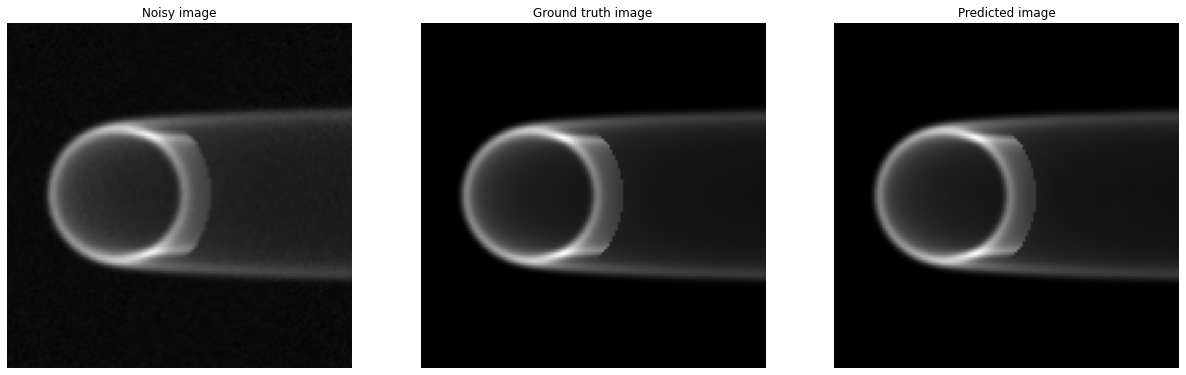

In [ ]:
visualize_predictions(model1, noisy_test_images1, gt_test_images1, 1)

In [ ]:
from skimage.metrics import peak_signal_noise_ratio

predicted_images = inference_batch_images(model1, noisy_test_images1)
psnr_original_mean = 0
psnr_prediction_mean = 0

for gt_img, noisy_img, predicted_img in zip(gt_test_images1, noisy_test_images1, predicted_images):
    psnr_original_mean += peak_signal_noise_ratio(gt_img, noisy_img)
    psnr_prediction_mean += peak_signal_noise_ratio(gt_img, predicted_img)

psnr_original_mean/=gt_test_images1.shape[0]
psnr_prediction_mean/=gt_test_images1.shape[0]
print("Original average gt-noisy PSNR ->", psnr_original_mean)
print("Predicted average gt-predicted PSNR ->", psnr_prediction_mean)

Original average gt-noisy PSNR -> 26.891310726576613
Predicted average gt-predicted PSNR -> 56.20953469491022


In [ ]:
from skimage.metrics import structural_similarity as ssim

predicted_images = inference_batch_images(model1, noisy_test_images1)
ssim_original_mean = 0
ssim_prediction_mean = 0

for gt_img, noisy_img, predicted_img in zip(gt_test_images1, noisy_test_images1, predicted_images):
    ssim_original_mean += ssim(gt_img, noisy_img, multichannel=True, data_range=noisy_img.max() - noisy_img.min())
    ssim_prediction_mean += ssim(gt_img, predicted_img, multichannel=True, data_range=predicted_img.max() - predicted_img.min())

ssim_original_mean/=gt_test_images1.shape[0]
ssim_prediction_mean/=gt_test_images1.shape[0]
print("Original average gt-noisy SSIM ->", ssim_original_mean)
print("Predicted average gt-predicted SSIM ->", ssim_prediction_mean)

Original average gt-noisy SSIM -> 0.45496089628848285
Predicted average gt-predicted SSIM -> 0.9989915791814389


g80

In [ ]:
noisy_test_paths1, gt_test_paths1 = get_images_paths("g80")

In [ ]:
print(noisy_test_paths1.shape)
print(gt_test_paths1.shape)

(1,)
(1,)


In [ ]:
noisy_test_images1 = get_images_in_mem(noisy_test_paths1)
gt_test_images1 = get_images_in_mem(gt_test_paths1)

print(noisy_test_images1.shape)
print(gt_test_images1.shape)

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

(1, 128, 128, 3)
(1, 128, 128, 3)


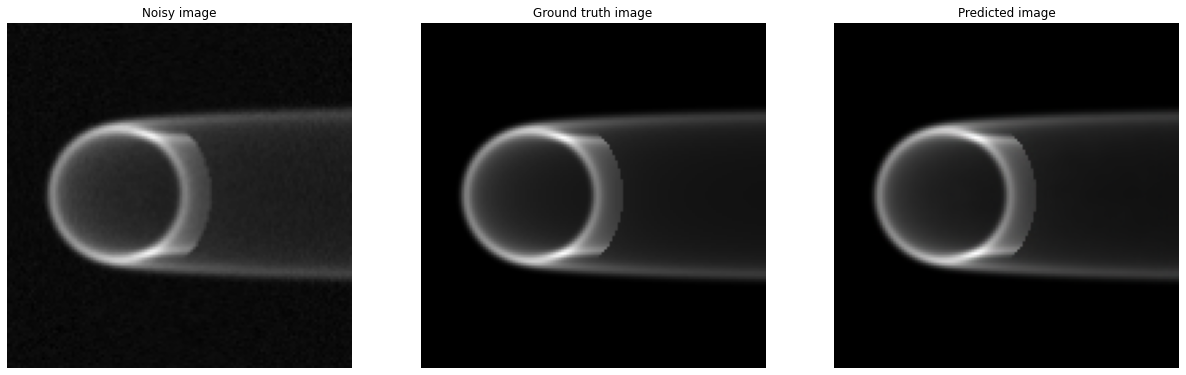

In [ ]:
visualize_predictions(model1, noisy_test_images1, gt_test_images1, 1)

In [ ]:
from skimage.metrics import peak_signal_noise_ratio

predicted_images = inference_batch_images(model1, noisy_test_images1)
psnr_original_mean = 0
psnr_prediction_mean = 0

for gt_img, noisy_img, predicted_img in zip(gt_test_images1, noisy_test_images1, predicted_images):
    psnr_original_mean += peak_signal_noise_ratio(gt_img, noisy_img)
    psnr_prediction_mean += peak_signal_noise_ratio(gt_img, predicted_img)

psnr_original_mean/=gt_test_images1.shape[0]
psnr_prediction_mean/=gt_test_images1.shape[0]
print("Original average gt-noisy PSNR ->", psnr_original_mean)
print("Predicted average gt-predicted PSNR ->", psnr_prediction_mean)

Original average gt-noisy PSNR -> 26.70169885773857
Predicted average gt-predicted PSNR -> 55.289721819836295


In [ ]:
from skimage.metrics import structural_similarity as ssim

predicted_images = inference_batch_images(model1, noisy_test_images1)
ssim_original_mean = 0
ssim_prediction_mean = 0

for gt_img, noisy_img, predicted_img in zip(gt_test_images1, noisy_test_images1, predicted_images):
    ssim_original_mean += ssim(gt_img, noisy_img, multichannel=True, data_range=noisy_img.max() - noisy_img.min())
    ssim_prediction_mean += ssim(gt_img, predicted_img, multichannel=True, data_range=predicted_img.max() - predicted_img.min())

ssim_original_mean/=gt_test_images1.shape[0]
ssim_prediction_mean/=gt_test_images1.shape[0]
print("Original average gt-noisy SSIM ->", ssim_original_mean)
print("Predicted average gt-predicted SSIM ->", ssim_prediction_mean)

Original average gt-noisy SSIM -> 0.4484739101958553
Predicted average gt-predicted SSIM -> 0.99890645926157


p10

In [ ]:
noisy_test_paths1, gt_test_paths1 = get_images_paths("p10")

In [ ]:
noisy_test_images1 = get_images_in_mem(noisy_test_paths1)
gt_test_images1 = get_images_in_mem(gt_test_paths1)

print(noisy_test_images1.shape)
print(gt_test_images1.shape)

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

(1, 128, 128, 3)
(1, 128, 128, 3)


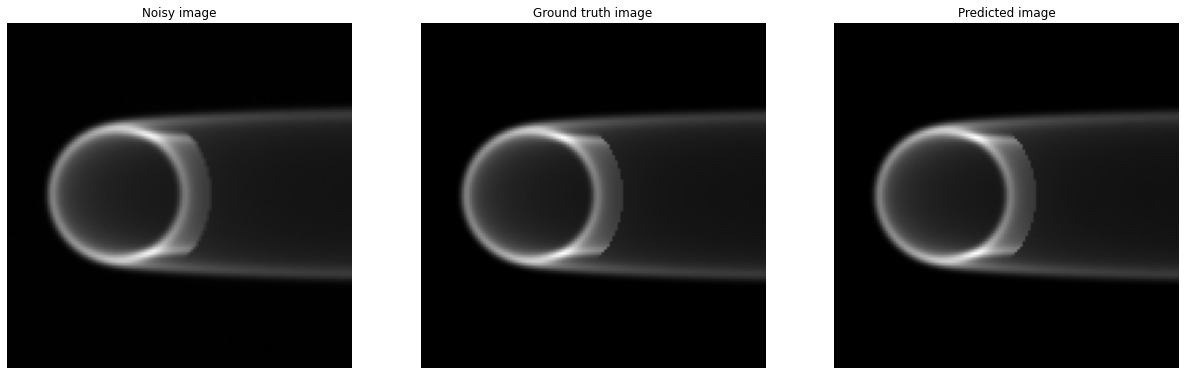

In [ ]:
visualize_predictions(model1, noisy_test_images1, gt_test_images1, 1)

In [ ]:
from skimage.metrics import peak_signal_noise_ratio

predicted_images = inference_batch_images(model1, noisy_test_images1)
psnr_original_mean = 0
psnr_prediction_mean = 0

for gt_img, noisy_img, predicted_img in zip(gt_test_images1, noisy_test_images1, predicted_images):
    psnr_original_mean += peak_signal_noise_ratio(gt_img, noisy_img)
    psnr_prediction_mean += peak_signal_noise_ratio(gt_img, predicted_img)

psnr_original_mean/=gt_test_images1.shape[0]
psnr_prediction_mean/=gt_test_images1.shape[0]
print("Original average gt-noisy PSNR ->", psnr_original_mean)
print("Predicted average gt-predicted PSNR ->", psnr_prediction_mean)

Original average gt-noisy PSNR -> 32.480120353005105
Predicted average gt-predicted PSNR -> 56.263632299065556


In [ ]:
from skimage.metrics import structural_similarity as ssim

predicted_images = inference_batch_images(model1, noisy_test_images1)
ssim_original_mean = 0
ssim_prediction_mean = 0

for gt_img, noisy_img, predicted_img in zip(gt_test_images1, noisy_test_images1, predicted_images):
    ssim_original_mean += ssim(gt_img, noisy_img, multichannel=True, data_range=noisy_img.max() - noisy_img.min())
    ssim_prediction_mean += ssim(gt_img, predicted_img, multichannel=True, data_range=predicted_img.max() - predicted_img.min())

ssim_original_mean/=gt_test_images1.shape[0]
ssim_prediction_mean/=gt_test_images1.shape[0]
print("Original average gt-noisy SSIM ->", ssim_original_mean)
print("Predicted average gt-predicted SSIM ->", ssim_prediction_mean)

Original average gt-noisy SSIM -> 0.8532651415552023
Predicted average gt-predicted SSIM -> 0.9990807979057009


p20

In [ ]:
noisy_test_paths1, gt_test_paths1 = get_images_paths("p20")

In [ ]:
noisy_test_images1 = get_images_in_mem(noisy_test_paths1)
gt_test_images1 = get_images_in_mem(gt_test_paths1)

print(noisy_test_images1.shape)
print(gt_test_images1.shape)

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

(1, 128, 128, 3)
(1, 128, 128, 3)


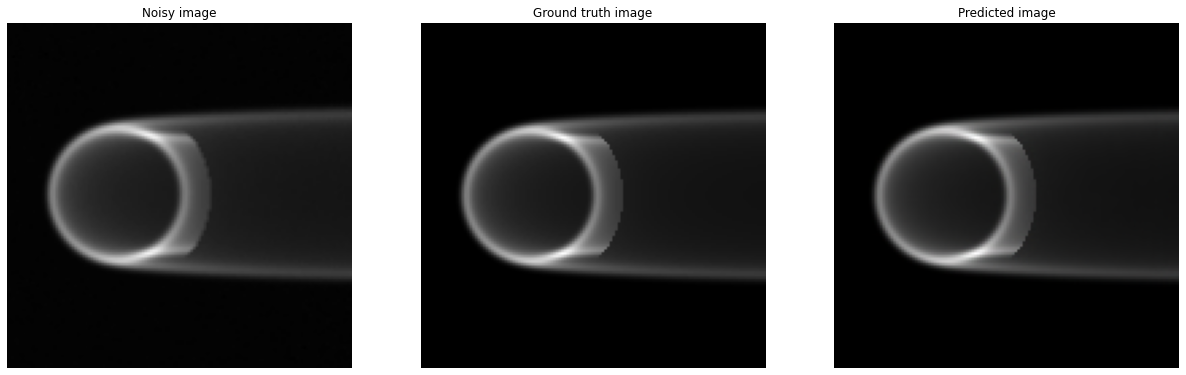

In [ ]:
visualize_predictions(model1, noisy_test_images1, gt_test_images1, 1)

In [ ]:
from skimage.metrics import peak_signal_noise_ratio

predicted_images = inference_batch_images(model1, noisy_test_images1)
psnr_original_mean = 0
psnr_prediction_mean = 0

for gt_img, noisy_img, predicted_img in zip(gt_test_images1, noisy_test_images1, predicted_images):
    psnr_original_mean += peak_signal_noise_ratio(gt_img, noisy_img)
    psnr_prediction_mean += peak_signal_noise_ratio(gt_img, predicted_img)

psnr_original_mean/=gt_test_images1.shape[0]
psnr_prediction_mean/=gt_test_images1.shape[0]
print("Original average gt-noisy PSNR ->", psnr_original_mean)
print("Predicted average gt-predicted PSNR ->", psnr_prediction_mean)

Original average gt-noisy PSNR -> 31.54574638181726
Predicted average gt-predicted PSNR -> 57.130935749949884


In [ ]:
from skimage.metrics import structural_similarity as ssim

predicted_images = inference_batch_images(model1, noisy_test_images1)
ssim_original_mean = 0
ssim_prediction_mean = 0

for gt_img, noisy_img, predicted_img in zip(gt_test_images1, noisy_test_images1, predicted_images):
    ssim_original_mean += ssim(gt_img, noisy_img, multichannel=True, data_range=noisy_img.max() - noisy_img.min())
    ssim_prediction_mean += ssim(gt_img, predicted_img, multichannel=True, data_range=predicted_img.max() - predicted_img.min())

ssim_original_mean/=gt_test_images1.shape[0]
ssim_prediction_mean/=gt_test_images1.shape[0]
print("Original average gt-noisy SSIM ->", ssim_original_mean)
print("Predicted average gt-predicted SSIM ->", ssim_prediction_mean)

Original average gt-noisy SSIM -> 0.6402435703597179
Predicted average gt-predicted SSIM -> 0.9991370754302776


p30

In [ ]:
noisy_test_paths1, gt_test_paths1 = get_images_paths("p30")

In [ ]:
noisy_test_images1 = get_images_in_mem(noisy_test_paths1)
gt_test_images1 = get_images_in_mem(gt_test_paths1)

print(noisy_test_images1.shape)
print(gt_test_images1.shape)

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

(1, 128, 128, 3)
(1, 128, 128, 3)


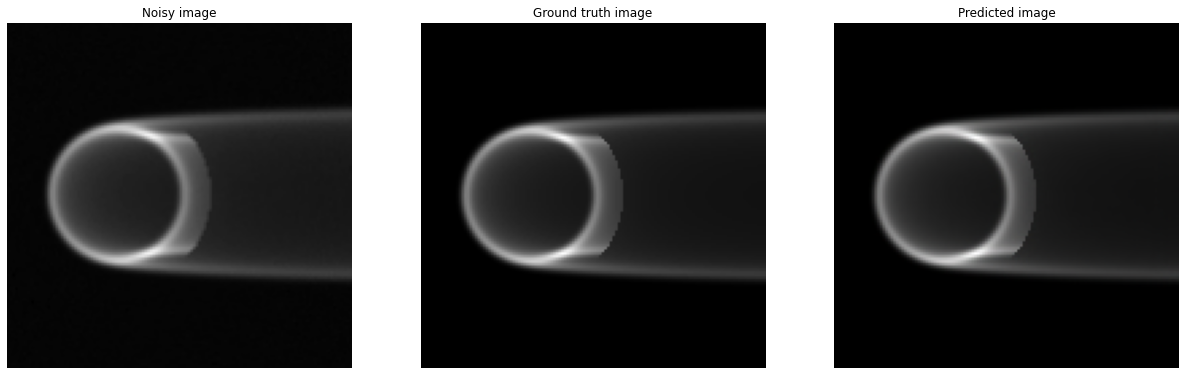

In [ ]:
visualize_predictions(model1, noisy_test_images1, gt_test_images1, 1)

In [ ]:
from skimage.metrics import peak_signal_noise_ratio

predicted_images = inference_batch_images(model1, noisy_test_images1)
psnr_original_mean = 0
psnr_prediction_mean = 0

for gt_img, noisy_img, predicted_img in zip(gt_test_images1, noisy_test_images1, predicted_images):
    psnr_original_mean += peak_signal_noise_ratio(gt_img, noisy_img)
    psnr_prediction_mean += peak_signal_noise_ratio(gt_img, predicted_img)

psnr_original_mean/=gt_test_images1.shape[0]
psnr_prediction_mean/=gt_test_images1.shape[0]
print("Original average gt-noisy PSNR ->", psnr_original_mean)
print("Predicted average gt-predicted PSNR ->", psnr_prediction_mean)

Original average gt-noisy PSNR -> 30.277114185877853
Predicted average gt-predicted PSNR -> 56.768080057538384


In [ ]:
from skimage.metrics import structural_similarity as ssim

predicted_images = inference_batch_images(model1, noisy_test_images1)
ssim_original_mean = 0
ssim_prediction_mean = 0

for gt_img, noisy_img, predicted_img in zip(gt_test_images1, noisy_test_images1, predicted_images):
    ssim_original_mean += ssim(gt_img, noisy_img, multichannel=True, data_range=noisy_img.max() - noisy_img.min())
    ssim_prediction_mean += ssim(gt_img, predicted_img, multichannel=True, data_range=predicted_img.max() - predicted_img.min())

ssim_original_mean/=gt_test_images1.shape[0]
ssim_prediction_mean/=gt_test_images1.shape[0]
print("Original average gt-noisy SSIM ->", ssim_original_mean)
print("Predicted average gt-predicted SSIM ->", ssim_prediction_mean)

Original average gt-noisy SSIM -> 0.5447035097690273
Predicted average gt-predicted SSIM -> 0.999167723809112


p40

In [ ]:
noisy_test_paths1, gt_test_paths1 = get_images_paths("p40")

In [ ]:
noisy_test_images1 = get_images_in_mem(noisy_test_paths1)
gt_test_images1 = get_images_in_mem(gt_test_paths1)

print(noisy_test_images1.shape)
print(gt_test_images1.shape)

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

(1, 128, 128, 3)
(1, 128, 128, 3)


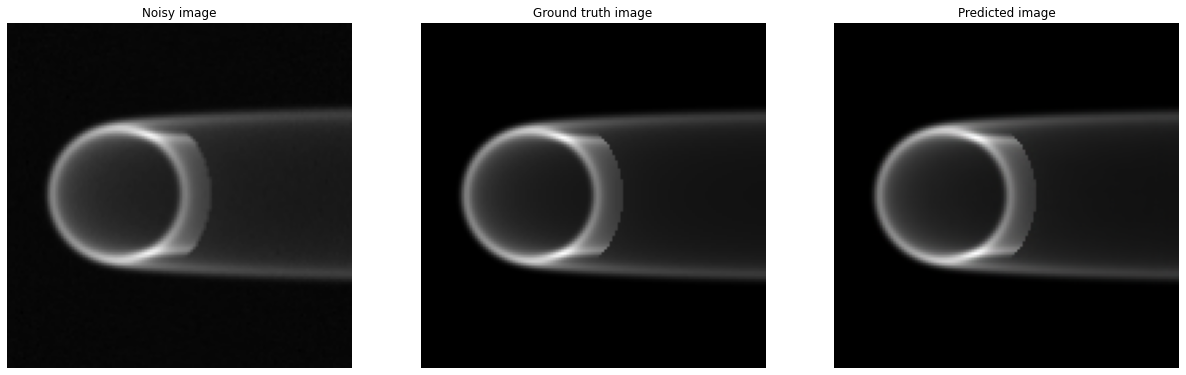

In [ ]:
visualize_predictions(model1, noisy_test_images1, gt_test_images1, 1)

In [ ]:
from skimage.metrics import peak_signal_noise_ratio

predicted_images = inference_batch_images(model1, noisy_test_images1)
psnr_original_mean = 0
psnr_prediction_mean = 0

for gt_img, noisy_img, predicted_img in zip(gt_test_images1, noisy_test_images1, predicted_images):
    psnr_original_mean += peak_signal_noise_ratio(gt_img, noisy_img)
    psnr_prediction_mean += peak_signal_noise_ratio(gt_img, predicted_img)

psnr_original_mean/=gt_test_images1.shape[0]
psnr_prediction_mean/=gt_test_images1.shape[0]
print("Original average gt-noisy PSNR ->", psnr_original_mean)
print("Predicted average gt-predicted PSNR ->", psnr_prediction_mean)

Original average gt-noisy PSNR -> 28.915545457462656
Predicted average gt-predicted PSNR -> 56.60548247855466


In [ ]:
from skimage.metrics import structural_similarity as ssim

predicted_images = inference_batch_images(model1, noisy_test_images1)
ssim_original_mean = 0
ssim_prediction_mean = 0

for gt_img, noisy_img, predicted_img in zip(gt_test_images1, noisy_test_images1, predicted_images):
    ssim_original_mean += ssim(gt_img, noisy_img, multichannel=True, data_range=noisy_img.max() - noisy_img.min())
    ssim_prediction_mean += ssim(gt_img, predicted_img, multichannel=True, data_range=predicted_img.max() - predicted_img.min())

ssim_original_mean/=gt_test_images1.shape[0]
ssim_prediction_mean/=gt_test_images1.shape[0]
print("Original average gt-noisy SSIM ->", ssim_original_mean)
print("Predicted average gt-predicted SSIM ->", ssim_prediction_mean)

Original average gt-noisy SSIM -> 0.4984781119879527
Predicted average gt-predicted SSIM -> 0.9991371539945115


p50

In [ ]:
noisy_test_paths1, gt_test_paths1 = get_images_paths("p50")

In [ ]:
noisy_test_images1 = get_images_in_mem(noisy_test_paths1)
gt_test_images1 = get_images_in_mem(gt_test_paths1)

print(noisy_test_images1.shape)
print(gt_test_images1.shape)

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

(1, 128, 128, 3)
(1, 128, 128, 3)


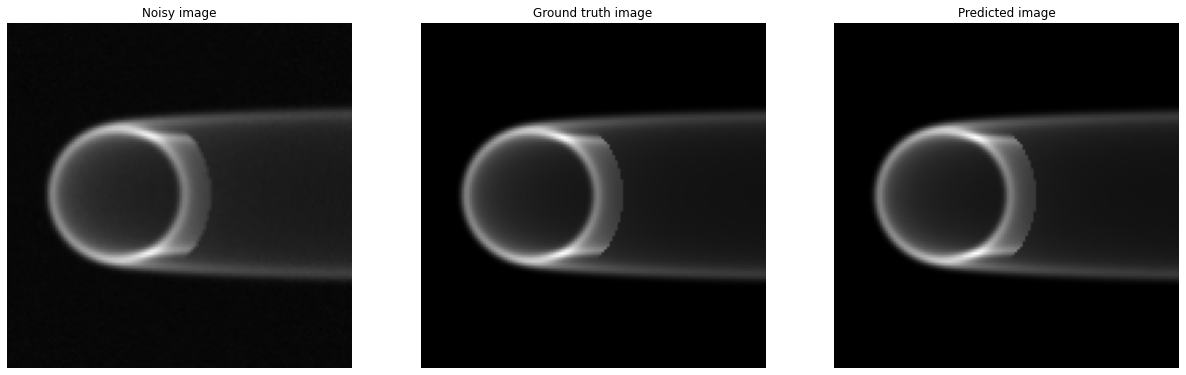

In [ ]:
visualize_predictions(model1, noisy_test_images1, gt_test_images1, 1)

In [ ]:
from skimage.metrics import peak_signal_noise_ratio

predicted_images = inference_batch_images(model1, noisy_test_images1)
psnr_original_mean = 0
psnr_prediction_mean = 0

for gt_img, noisy_img, predicted_img in zip(gt_test_images1, noisy_test_images1, predicted_images):
    psnr_original_mean += peak_signal_noise_ratio(gt_img, noisy_img)
    psnr_prediction_mean += peak_signal_noise_ratio(gt_img, predicted_img)

psnr_original_mean/=gt_test_images1.shape[0]
psnr_prediction_mean/=gt_test_images1.shape[0]
print("Original average gt-noisy PSNR ->", psnr_original_mean)
print("Predicted average gt-predicted PSNR ->", psnr_prediction_mean)

Original average gt-noisy PSNR -> 28.439412130223197
Predicted average gt-predicted PSNR -> 56.5831824210635


In [ ]:
from skimage.metrics import structural_similarity as ssim

predicted_images = inference_batch_images(model1, noisy_test_images1)
ssim_original_mean = 0
ssim_prediction_mean = 0

for gt_img, noisy_img, predicted_img in zip(gt_test_images1, noisy_test_images1, predicted_images):
    ssim_original_mean += ssim(gt_img, noisy_img, multichannel=True, data_range=noisy_img.max() - noisy_img.min())
    ssim_prediction_mean += ssim(gt_img, predicted_img, multichannel=True, data_range=predicted_img.max() - predicted_img.min())

ssim_original_mean/=gt_test_images1.shape[0]
ssim_prediction_mean/=gt_test_images1.shape[0]
print("Original average gt-noisy SSIM ->", ssim_original_mean)
print("Predicted average gt-predicted SSIM ->", ssim_prediction_mean)

Original average gt-noisy SSIM -> 0.48524762044662434
Predicted average gt-predicted SSIM -> 0.9991314298802818


p60

In [ ]:
noisy_test_paths1, gt_test_paths1 = get_images_paths("p60")

In [ ]:
noisy_test_images1 = get_images_in_mem(noisy_test_paths1)
gt_test_images1 = get_images_in_mem(gt_test_paths1)

print(noisy_test_images1.shape)
print(gt_test_images1.shape)

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

(1, 128, 128, 3)
(1, 128, 128, 3)


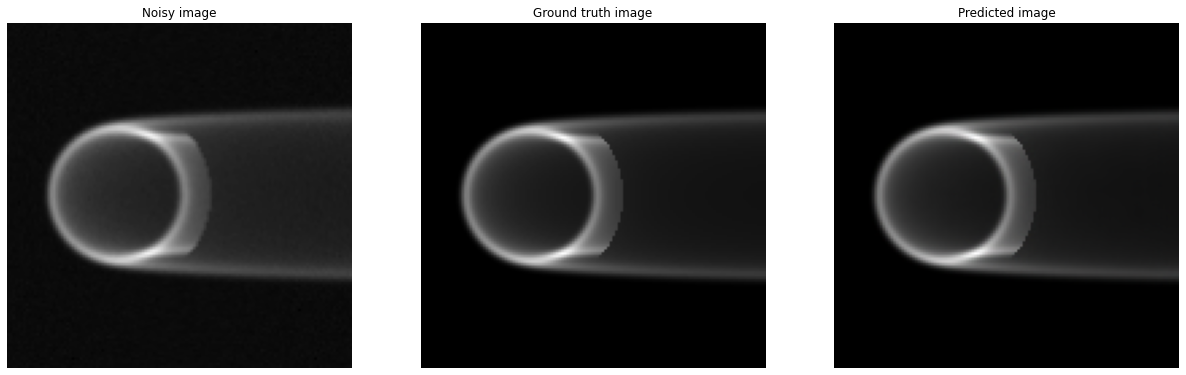

In [ ]:
visualize_predictions(model1, noisy_test_images1, gt_test_images1, 1)

In [ ]:
from skimage.metrics import peak_signal_noise_ratio

predicted_images = inference_batch_images(model1, noisy_test_images1)
psnr_original_mean = 0
psnr_prediction_mean = 0

for gt_img, noisy_img, predicted_img in zip(gt_test_images1, noisy_test_images1, predicted_images):
    psnr_original_mean += peak_signal_noise_ratio(gt_img, noisy_img)
    psnr_prediction_mean += peak_signal_noise_ratio(gt_img, predicted_img)

psnr_original_mean/=gt_test_images1.shape[0]
psnr_prediction_mean/=gt_test_images1.shape[0]
print("Original average gt-noisy PSNR ->", psnr_original_mean)
print("Predicted average gt-predicted PSNR ->", psnr_prediction_mean)

Original average gt-noisy PSNR -> 26.506632092944034
Predicted average gt-predicted PSNR -> 56.36272182389739


In [ ]:
from skimage.metrics import structural_similarity as ssim

predicted_images = inference_batch_images(model1, noisy_test_images1)
ssim_original_mean = 0
ssim_prediction_mean = 0

for gt_img, noisy_img, predicted_img in zip(gt_test_images1, noisy_test_images1, predicted_images):
    ssim_original_mean += ssim(gt_img, noisy_img, multichannel=True, data_range=noisy_img.max() - noisy_img.min())
    ssim_prediction_mean += ssim(gt_img, predicted_img, multichannel=True, data_range=predicted_img.max() - predicted_img.min())

ssim_original_mean/=gt_test_images1.shape[0]
ssim_prediction_mean/=gt_test_images1.shape[0]
print("Original average gt-noisy SSIM ->", ssim_original_mean)
print("Predicted average gt-predicted SSIM ->", ssim_prediction_mean)

Original average gt-noisy SSIM -> 0.4539462278128801
Predicted average gt-predicted SSIM -> 0.9990004816075881


p70

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

(1, 128, 128, 3)
(1, 128, 128, 3)


Original average gt-noisy PSNR -> 25.467015639063998
Predicted average gt-predicted PSNR -> 55.76499965781366
Original average gt-noisy SSIM -> 0.44127795049965973
Predicted average gt-predicted SSIM -> 0.9988802032687566


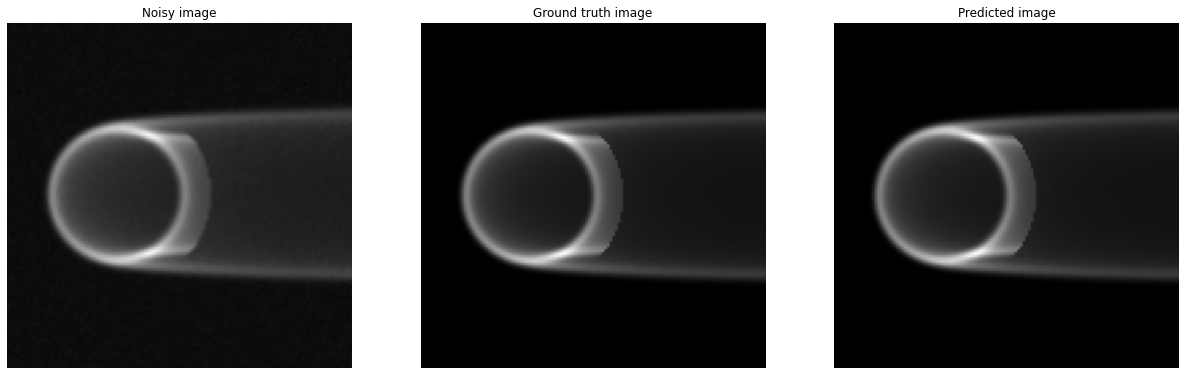

In [ ]:
noisy_test_paths1, gt_test_paths1 = get_images_paths("p70")

noisy_test_images1 = get_images_in_mem(noisy_test_paths1)
gt_test_images1 = get_images_in_mem(gt_test_paths1)

print(noisy_test_images1.shape)
print(gt_test_images1.shape)

visualize_predictions(model1, noisy_test_images1, gt_test_images1, 1)

from skimage.metrics import peak_signal_noise_ratio

predicted_images = inference_batch_images(model1, noisy_test_images1)
psnr_original_mean = 0
psnr_prediction_mean = 0

for gt_img, noisy_img, predicted_img in zip(gt_test_images1, noisy_test_images1, predicted_images):
    psnr_original_mean += peak_signal_noise_ratio(gt_img, noisy_img)
    psnr_prediction_mean += peak_signal_noise_ratio(gt_img, predicted_img)

psnr_original_mean/=gt_test_images1.shape[0]
psnr_prediction_mean/=gt_test_images1.shape[0]
print("Original average gt-noisy PSNR ->", psnr_original_mean)
print("Predicted average gt-predicted PSNR ->", psnr_prediction_mean)

from skimage.metrics import structural_similarity as ssim

predicted_images = inference_batch_images(model1, noisy_test_images1)
ssim_original_mean = 0
ssim_prediction_mean = 0

for gt_img, noisy_img, predicted_img in zip(gt_test_images1, noisy_test_images1, predicted_images):
    ssim_original_mean += ssim(gt_img, noisy_img, multichannel=True, data_range=noisy_img.max() - noisy_img.min())
    ssim_prediction_mean += ssim(gt_img, predicted_img, multichannel=True, data_range=predicted_img.max() - predicted_img.min())

ssim_original_mean/=gt_test_images1.shape[0]
ssim_prediction_mean/=gt_test_images1.shape[0]
print("Original average gt-noisy SSIM ->", ssim_original_mean)
print("Predicted average gt-predicted SSIM ->", ssim_prediction_mean)


p80

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

(1, 128, 128, 3)
(1, 128, 128, 3)
Original average gt-noisy PSNR -> 25.971434963281382
Predicted average gt-predicted PSNR -> 54.998706367232074
Original average gt-noisy SSIM -> 0.4439433145477223
Predicted average gt-predicted SSIM -> 0.9989243761772338


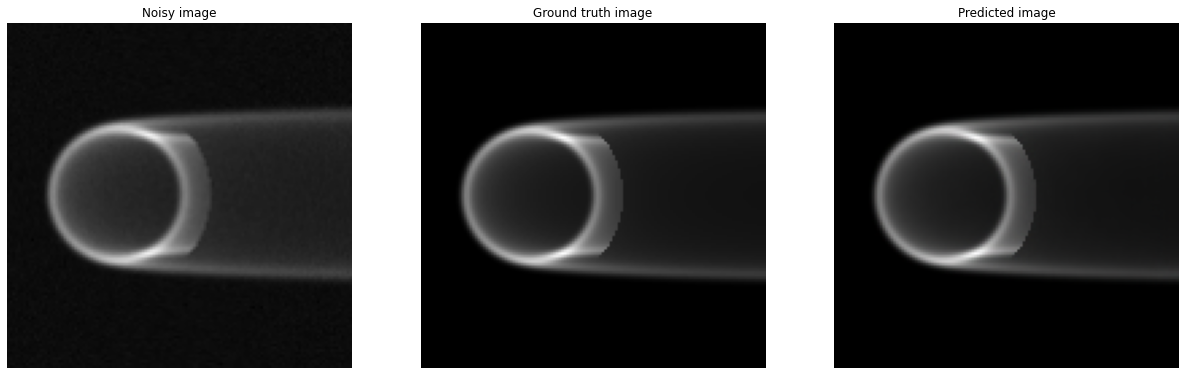

In [ ]:
noisy_test_paths1, gt_test_paths1 = get_images_paths("p80")

noisy_test_images1 = get_images_in_mem(noisy_test_paths1)
gt_test_images1 = get_images_in_mem(gt_test_paths1)

print(noisy_test_images1.shape)
print(gt_test_images1.shape)

visualize_predictions(model1, noisy_test_images1, gt_test_images1, 1)

from skimage.metrics import peak_signal_noise_ratio

predicted_images = inference_batch_images(model1, noisy_test_images1)
psnr_original_mean = 0
psnr_prediction_mean = 0

for gt_img, noisy_img, predicted_img in zip(gt_test_images1, noisy_test_images1, predicted_images):
    psnr_original_mean += peak_signal_noise_ratio(gt_img, noisy_img)
    psnr_prediction_mean += peak_signal_noise_ratio(gt_img, predicted_img)

psnr_original_mean/=gt_test_images1.shape[0]
psnr_prediction_mean/=gt_test_images1.shape[0]
print("Original average gt-noisy PSNR ->", psnr_original_mean)
print("Predicted average gt-predicted PSNR ->", psnr_prediction_mean)

from skimage.metrics import structural_similarity as ssim

predicted_images = inference_batch_images(model1, noisy_test_images1)
ssim_original_mean = 0
ssim_prediction_mean = 0

for gt_img, noisy_img, predicted_img in zip(gt_test_images1, noisy_test_images1, predicted_images):
    ssim_original_mean += ssim(gt_img, noisy_img, multichannel=True, data_range=noisy_img.max() - noisy_img.min())
    ssim_prediction_mean += ssim(gt_img, predicted_img, multichannel=True, data_range=predicted_img.max() - predicted_img.min())

ssim_original_mean/=gt_test_images1.shape[0]
ssim_prediction_mean/=gt_test_images1.shape[0]
print("Original average gt-noisy SSIM ->", ssim_original_mean)
print("Predicted average gt-predicted SSIM ->", ssim_prediction_mean)


s10

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

(1, 128, 128, 3)
(1, 128, 128, 3)
Original average gt-noisy PSNR -> 15.343191705424633
Predicted average gt-predicted PSNR -> 42.42066011932684
Original average gt-noisy SSIM -> 0.18388197985311727
Predicted average gt-predicted SSIM -> 0.9916361851988644


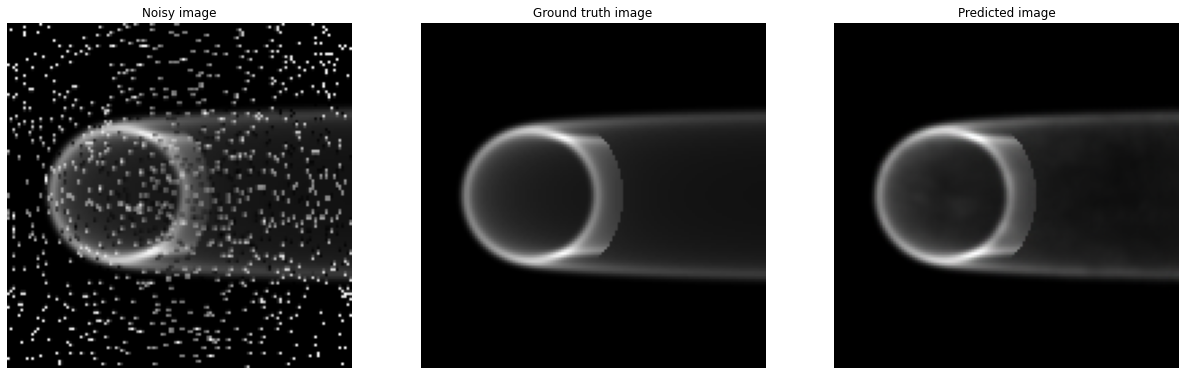

In [ ]:
noisy_test_paths1, gt_test_paths1 = get_images_paths("s10")

noisy_test_images1 = get_images_in_mem(noisy_test_paths1)
gt_test_images1 = get_images_in_mem(gt_test_paths1)

print(noisy_test_images1.shape)
print(gt_test_images1.shape)

visualize_predictions(model1, noisy_test_images1, gt_test_images1, 1)

from skimage.metrics import peak_signal_noise_ratio

predicted_images = inference_batch_images(model1, noisy_test_images1)
psnr_original_mean = 0
psnr_prediction_mean = 0

for gt_img, noisy_img, predicted_img in zip(gt_test_images1, noisy_test_images1, predicted_images):
    psnr_original_mean += peak_signal_noise_ratio(gt_img, noisy_img)
    psnr_prediction_mean += peak_signal_noise_ratio(gt_img, predicted_img)

psnr_original_mean/=gt_test_images1.shape[0]
psnr_prediction_mean/=gt_test_images1.shape[0]
print("Original average gt-noisy PSNR ->", psnr_original_mean)
print("Predicted average gt-predicted PSNR ->", psnr_prediction_mean)

from skimage.metrics import structural_similarity as ssim

predicted_images = inference_batch_images(model1, noisy_test_images1)
ssim_original_mean = 0
ssim_prediction_mean = 0

for gt_img, noisy_img, predicted_img in zip(gt_test_images1, noisy_test_images1, predicted_images):
    ssim_original_mean += ssim(gt_img, noisy_img, multichannel=True, data_range=noisy_img.max() - noisy_img.min())
    ssim_prediction_mean += ssim(gt_img, predicted_img, multichannel=True, data_range=predicted_img.max() - predicted_img.min())

ssim_original_mean/=gt_test_images1.shape[0]
ssim_prediction_mean/=gt_test_images1.shape[0]
print("Original average gt-noisy SSIM ->", ssim_original_mean)
print("Predicted average gt-predicted SSIM ->", ssim_prediction_mean)


s20

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

(1, 128, 128, 3)
(1, 128, 128, 3)


Original average gt-noisy PSNR -> 12.826926584045893
Predicted average gt-predicted PSNR -> 42.123442175928986
Original average gt-noisy SSIM -> 0.1031111614128446
Predicted average gt-predicted SSIM -> 0.9894820043313381


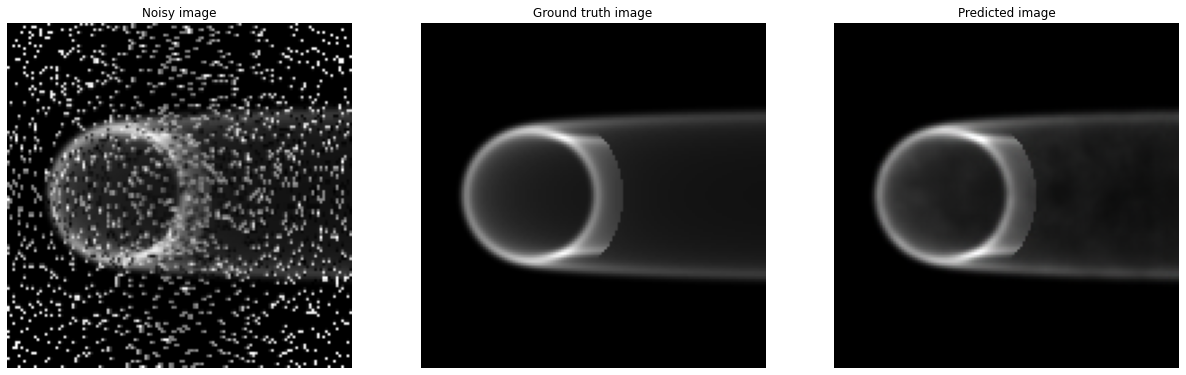

In [ ]:
noisy_test_paths1, gt_test_paths1 = get_images_paths("s20")

noisy_test_images1 = get_images_in_mem(noisy_test_paths1)
gt_test_images1 = get_images_in_mem(gt_test_paths1)

print(noisy_test_images1.shape)
print(gt_test_images1.shape)

visualize_predictions(model1, noisy_test_images1, gt_test_images1, 1)

from skimage.metrics import peak_signal_noise_ratio

predicted_images = inference_batch_images(model1, noisy_test_images1)
psnr_original_mean = 0
psnr_prediction_mean = 0

for gt_img, noisy_img, predicted_img in zip(gt_test_images1, noisy_test_images1, predicted_images):
    psnr_original_mean += peak_signal_noise_ratio(gt_img, noisy_img)
    psnr_prediction_mean += peak_signal_noise_ratio(gt_img, predicted_img)

psnr_original_mean/=gt_test_images1.shape[0]
psnr_prediction_mean/=gt_test_images1.shape[0]
print("Original average gt-noisy PSNR ->", psnr_original_mean)
print("Predicted average gt-predicted PSNR ->", psnr_prediction_mean)

from skimage.metrics import structural_similarity as ssim

predicted_images = inference_batch_images(model1, noisy_test_images1)
ssim_original_mean = 0
ssim_prediction_mean = 0

for gt_img, noisy_img, predicted_img in zip(gt_test_images1, noisy_test_images1, predicted_images):
    ssim_original_mean += ssim(gt_img, noisy_img, multichannel=True, data_range=noisy_img.max() - noisy_img.min())
    ssim_prediction_mean += ssim(gt_img, predicted_img, multichannel=True, data_range=predicted_img.max() - predicted_img.min())

ssim_original_mean/=gt_test_images1.shape[0]
ssim_prediction_mean/=gt_test_images1.shape[0]
print("Original average gt-noisy SSIM ->", ssim_original_mean)
print("Predicted average gt-predicted SSIM ->", ssim_prediction_mean)


s30

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

(1, 128, 128, 3)
(1, 128, 128, 3)
Original average gt-noisy PSNR -> 10.721734094321022
Predicted average gt-predicted PSNR -> 42.87245322041824
Original average gt-noisy SSIM -> 0.07440870057297067
Predicted average gt-predicted SSIM -> 0.9906108044653278


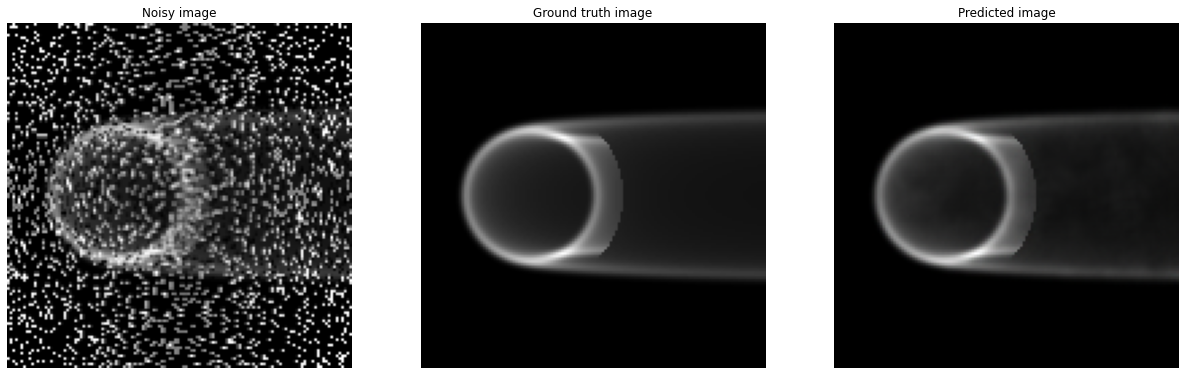

In [ ]:
noisy_test_paths1, gt_test_paths1 = get_images_paths("s30")

noisy_test_images1 = get_images_in_mem(noisy_test_paths1)
gt_test_images1 = get_images_in_mem(gt_test_paths1)

print(noisy_test_images1.shape)
print(gt_test_images1.shape)

visualize_predictions(model1, noisy_test_images1, gt_test_images1, 1)

from skimage.metrics import peak_signal_noise_ratio

predicted_images = inference_batch_images(model1, noisy_test_images1)
psnr_original_mean = 0
psnr_prediction_mean = 0

for gt_img, noisy_img, predicted_img in zip(gt_test_images1, noisy_test_images1, predicted_images):
    psnr_original_mean += peak_signal_noise_ratio(gt_img, noisy_img)
    psnr_prediction_mean += peak_signal_noise_ratio(gt_img, predicted_img)

psnr_original_mean/=gt_test_images1.shape[0]
psnr_prediction_mean/=gt_test_images1.shape[0]
print("Original average gt-noisy PSNR ->", psnr_original_mean)
print("Predicted average gt-predicted PSNR ->", psnr_prediction_mean)

from skimage.metrics import structural_similarity as ssim

predicted_images = inference_batch_images(model1, noisy_test_images1)
ssim_original_mean = 0
ssim_prediction_mean = 0

for gt_img, noisy_img, predicted_img in zip(gt_test_images1, noisy_test_images1, predicted_images):
    ssim_original_mean += ssim(gt_img, noisy_img, multichannel=True, data_range=noisy_img.max() - noisy_img.min())
    ssim_prediction_mean += ssim(gt_img, predicted_img, multichannel=True, data_range=predicted_img.max() - predicted_img.min())

ssim_original_mean/=gt_test_images1.shape[0]
ssim_prediction_mean/=gt_test_images1.shape[0]
print("Original average gt-noisy SSIM ->", ssim_original_mean)
print("Predicted average gt-predicted SSIM ->", ssim_prediction_mean)


s40

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

(1, 128, 128, 3)
(1, 128, 128, 3)


Original average gt-noisy PSNR -> 9.50256504536793
Predicted average gt-predicted PSNR -> 42.66002721942256
Original average gt-noisy SSIM -> 0.05138084032866618
Predicted average gt-predicted SSIM -> 0.9914717934045615


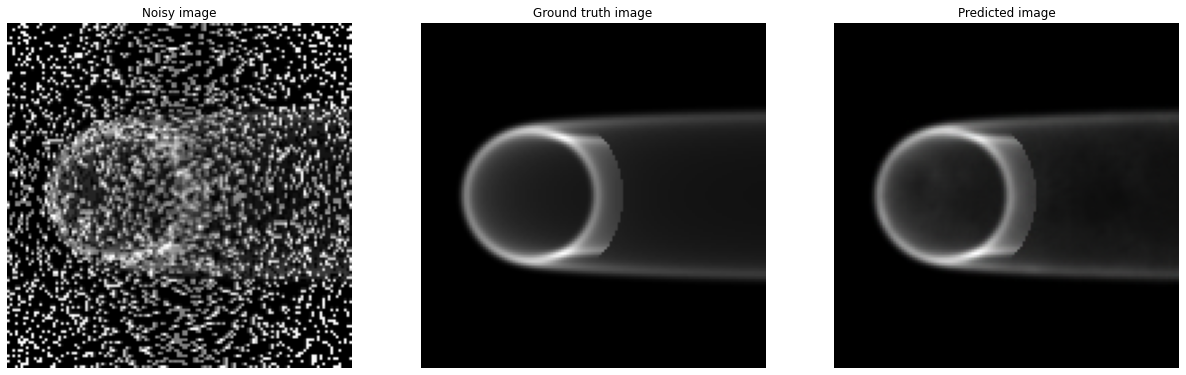

In [ ]:
noisy_test_paths1, gt_test_paths1 = get_images_paths("s40")

noisy_test_images1 = get_images_in_mem(noisy_test_paths1)
gt_test_images1 = get_images_in_mem(gt_test_paths1)

print(noisy_test_images1.shape)
print(gt_test_images1.shape)

visualize_predictions(model1, noisy_test_images1, gt_test_images1, 1)

from skimage.metrics import peak_signal_noise_ratio

predicted_images = inference_batch_images(model1, noisy_test_images1)
psnr_original_mean = 0
psnr_prediction_mean = 0

for gt_img, noisy_img, predicted_img in zip(gt_test_images1, noisy_test_images1, predicted_images):
    psnr_original_mean += peak_signal_noise_ratio(gt_img, noisy_img)
    psnr_prediction_mean += peak_signal_noise_ratio(gt_img, predicted_img)

psnr_original_mean/=gt_test_images1.shape[0]
psnr_prediction_mean/=gt_test_images1.shape[0]
print("Original average gt-noisy PSNR ->", psnr_original_mean)
print("Predicted average gt-predicted PSNR ->", psnr_prediction_mean)

from skimage.metrics import structural_similarity as ssim

predicted_images = inference_batch_images(model1, noisy_test_images1)
ssim_original_mean = 0
ssim_prediction_mean = 0

for gt_img, noisy_img, predicted_img in zip(gt_test_images1, noisy_test_images1, predicted_images):
    ssim_original_mean += ssim(gt_img, noisy_img, multichannel=True, data_range=noisy_img.max() - noisy_img.min())
    ssim_prediction_mean += ssim(gt_img, predicted_img, multichannel=True, data_range=predicted_img.max() - predicted_img.min())

ssim_original_mean/=gt_test_images1.shape[0]
ssim_prediction_mean/=gt_test_images1.shape[0]
print("Original average gt-noisy SSIM ->", ssim_original_mean)
print("Predicted average gt-predicted SSIM ->", ssim_prediction_mean)


s50

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

(1, 128, 128, 3)
(1, 128, 128, 3)
Original average gt-noisy PSNR -> 8.056858116531686
Predicted average gt-predicted PSNR -> 43.085665741181025
Original average gt-noisy SSIM -> 0.040401617502778486
Predicted average gt-predicted SSIM -> 0.9927155660846984


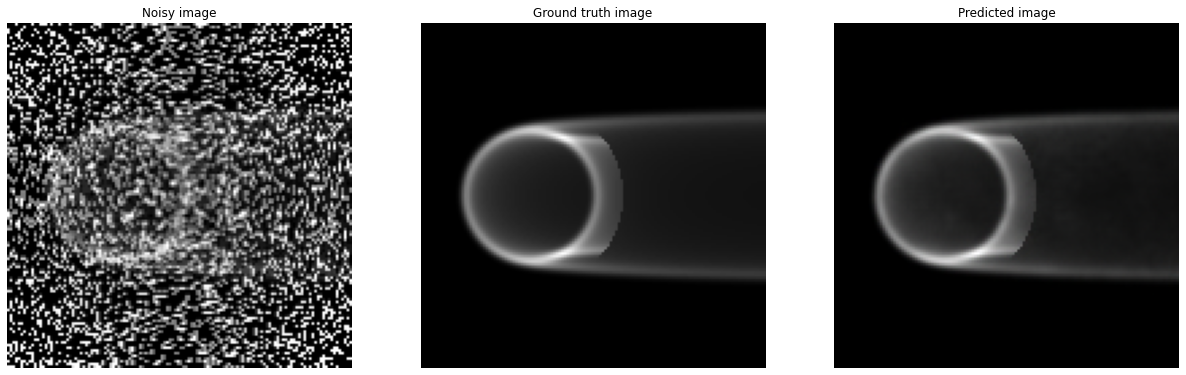

In [ ]:
noisy_test_paths1, gt_test_paths1 = get_images_paths("s50")

noisy_test_images1 = get_images_in_mem(noisy_test_paths1)
gt_test_images1 = get_images_in_mem(gt_test_paths1)

print(noisy_test_images1.shape)
print(gt_test_images1.shape)

visualize_predictions(model1, noisy_test_images1, gt_test_images1, 1)

from skimage.metrics import peak_signal_noise_ratio

predicted_images = inference_batch_images(model1, noisy_test_images1)
psnr_original_mean = 0
psnr_prediction_mean = 0

for gt_img, noisy_img, predicted_img in zip(gt_test_images1, noisy_test_images1, predicted_images):
    psnr_original_mean += peak_signal_noise_ratio(gt_img, noisy_img)
    psnr_prediction_mean += peak_signal_noise_ratio(gt_img, predicted_img)

psnr_original_mean/=gt_test_images1.shape[0]
psnr_prediction_mean/=gt_test_images1.shape[0]
print("Original average gt-noisy PSNR ->", psnr_original_mean)
print("Predicted average gt-predicted PSNR ->", psnr_prediction_mean)

from skimage.metrics import structural_similarity as ssim

predicted_images = inference_batch_images(model1, noisy_test_images1)
ssim_original_mean = 0
ssim_prediction_mean = 0

for gt_img, noisy_img, predicted_img in zip(gt_test_images1, noisy_test_images1, predicted_images):
    ssim_original_mean += ssim(gt_img, noisy_img, multichannel=True, data_range=noisy_img.max() - noisy_img.min())
    ssim_prediction_mean += ssim(gt_img, predicted_img, multichannel=True, data_range=predicted_img.max() - predicted_img.min())

ssim_original_mean/=gt_test_images1.shape[0]
ssim_prediction_mean/=gt_test_images1.shape[0]
print("Original average gt-noisy SSIM ->", ssim_original_mean)
print("Predicted average gt-predicted SSIM ->", ssim_prediction_mean)


s60

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

(1, 128, 128, 3)
(1, 128, 128, 3)


Original average gt-noisy PSNR -> 7.292692775641023
Predicted average gt-predicted PSNR -> 43.23348756651895
Original average gt-noisy SSIM -> 0.031088620316039404
Predicted average gt-predicted SSIM -> 0.9931909866901196


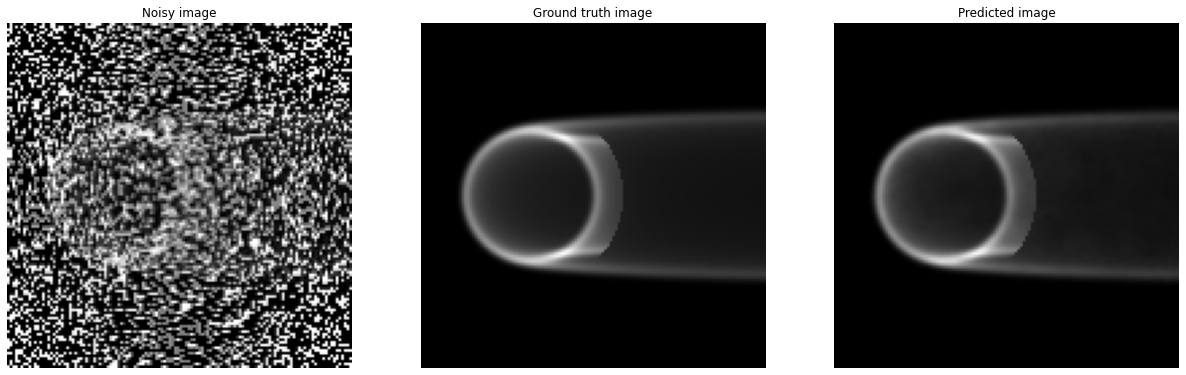

In [ ]:
noisy_test_paths1, gt_test_paths1 = get_images_paths("s60")

noisy_test_images1 = get_images_in_mem(noisy_test_paths1)
gt_test_images1 = get_images_in_mem(gt_test_paths1)

print(noisy_test_images1.shape)
print(gt_test_images1.shape)

visualize_predictions(model1, noisy_test_images1, gt_test_images1, 1)

from skimage.metrics import peak_signal_noise_ratio

predicted_images = inference_batch_images(model1, noisy_test_images1)
psnr_original_mean = 0
psnr_prediction_mean = 0

for gt_img, noisy_img, predicted_img in zip(gt_test_images1, noisy_test_images1, predicted_images):
    psnr_original_mean += peak_signal_noise_ratio(gt_img, noisy_img)
    psnr_prediction_mean += peak_signal_noise_ratio(gt_img, predicted_img)

psnr_original_mean/=gt_test_images1.shape[0]
psnr_prediction_mean/=gt_test_images1.shape[0]
print("Original average gt-noisy PSNR ->", psnr_original_mean)
print("Predicted average gt-predicted PSNR ->", psnr_prediction_mean)

from skimage.metrics import structural_similarity as ssim

predicted_images = inference_batch_images(model1, noisy_test_images1)
ssim_original_mean = 0
ssim_prediction_mean = 0

for gt_img, noisy_img, predicted_img in zip(gt_test_images1, noisy_test_images1, predicted_images):
    ssim_original_mean += ssim(gt_img, noisy_img, multichannel=True, data_range=noisy_img.max() - noisy_img.min())
    ssim_prediction_mean += ssim(gt_img, predicted_img, multichannel=True, data_range=predicted_img.max() - predicted_img.min())

ssim_original_mean/=gt_test_images1.shape[0]
ssim_prediction_mean/=gt_test_images1.shape[0]
print("Original average gt-noisy SSIM ->", ssim_original_mean)
print("Predicted average gt-predicted SSIM ->", ssim_prediction_mean)


s70

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

(1, 128, 128, 3)
(1, 128, 128, 3)


Original average gt-noisy PSNR -> 6.610032128617181
Predicted average gt-predicted PSNR -> 43.92823406846669
Original average gt-noisy SSIM -> 0.020360506280832563
Predicted average gt-predicted SSIM -> 0.993796967039116


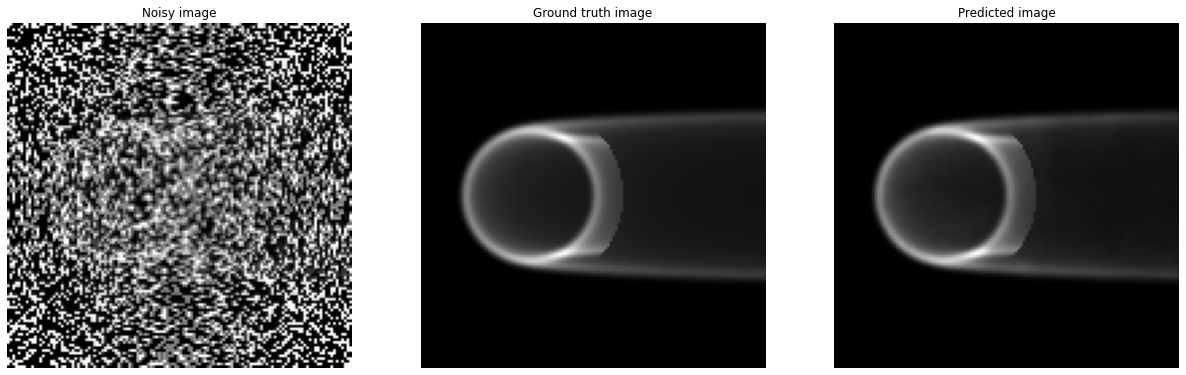

In [ ]:
noisy_test_paths1, gt_test_paths1 = get_images_paths("s70")

noisy_test_images1 = get_images_in_mem(noisy_test_paths1)
gt_test_images1 = get_images_in_mem(gt_test_paths1)

print(noisy_test_images1.shape)
print(gt_test_images1.shape)

visualize_predictions(model1, noisy_test_images1, gt_test_images1, 1)

from skimage.metrics import peak_signal_noise_ratio

predicted_images = inference_batch_images(model1, noisy_test_images1)
psnr_original_mean = 0
psnr_prediction_mean = 0

for gt_img, noisy_img, predicted_img in zip(gt_test_images1, noisy_test_images1, predicted_images):
    psnr_original_mean += peak_signal_noise_ratio(gt_img, noisy_img)
    psnr_prediction_mean += peak_signal_noise_ratio(gt_img, predicted_img)

psnr_original_mean/=gt_test_images1.shape[0]
psnr_prediction_mean/=gt_test_images1.shape[0]
print("Original average gt-noisy PSNR ->", psnr_original_mean)
print("Predicted average gt-predicted PSNR ->", psnr_prediction_mean)

from skimage.metrics import structural_similarity as ssim

predicted_images = inference_batch_images(model1, noisy_test_images1)
ssim_original_mean = 0
ssim_prediction_mean = 0

for gt_img, noisy_img, predicted_img in zip(gt_test_images1, noisy_test_images1, predicted_images):
    ssim_original_mean += ssim(gt_img, noisy_img, multichannel=True, data_range=noisy_img.max() - noisy_img.min())
    ssim_prediction_mean += ssim(gt_img, predicted_img, multichannel=True, data_range=predicted_img.max() - predicted_img.min())

ssim_original_mean/=gt_test_images1.shape[0]
ssim_prediction_mean/=gt_test_images1.shape[0]
print("Original average gt-noisy SSIM ->", ssim_original_mean)
print("Predicted average gt-predicted SSIM ->", ssim_prediction_mean)


s80

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

(1, 128, 128, 3)
(1, 128, 128, 3)


Original average gt-noisy PSNR -> 6.172902224570605
Predicted average gt-predicted PSNR -> 42.114008356642856
Original average gt-noisy SSIM -> 0.013540809663124398
Predicted average gt-predicted SSIM -> 0.9935222843423036


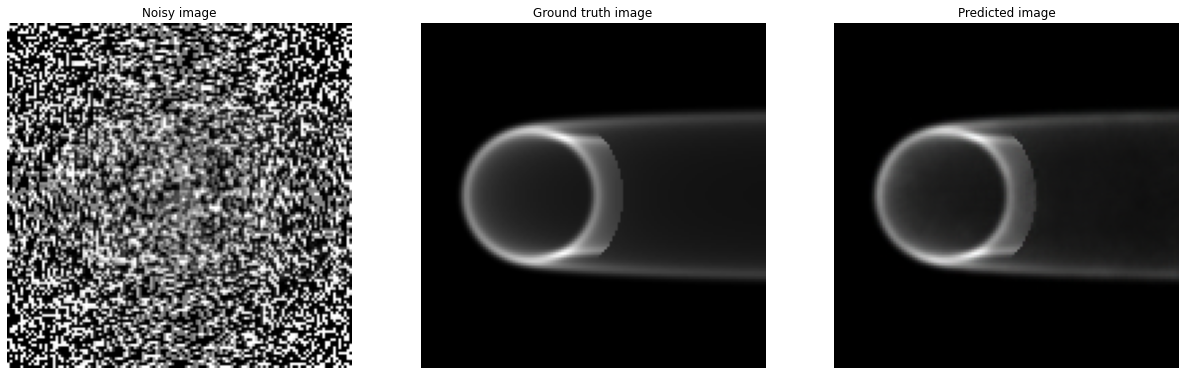

In [ ]:
noisy_test_paths1, gt_test_paths1 = get_images_paths("s80")

noisy_test_images1 = get_images_in_mem(noisy_test_paths1)
gt_test_images1 = get_images_in_mem(gt_test_paths1)

print(noisy_test_images1.shape)
print(gt_test_images1.shape)

visualize_predictions(model1, noisy_test_images1, gt_test_images1, 1)

from skimage.metrics import peak_signal_noise_ratio

predicted_images = inference_batch_images(model1, noisy_test_images1)
psnr_original_mean = 0
psnr_prediction_mean = 0

for gt_img, noisy_img, predicted_img in zip(gt_test_images1, noisy_test_images1, predicted_images):
    psnr_original_mean += peak_signal_noise_ratio(gt_img, noisy_img)
    psnr_prediction_mean += peak_signal_noise_ratio(gt_img, predicted_img)

psnr_original_mean/=gt_test_images1.shape[0]
psnr_prediction_mean/=gt_test_images1.shape[0]
print("Original average gt-noisy PSNR ->", psnr_original_mean)
print("Predicted average gt-predicted PSNR ->", psnr_prediction_mean)

from skimage.metrics import structural_similarity as ssim

predicted_images = inference_batch_images(model1, noisy_test_images1)
ssim_original_mean = 0
ssim_prediction_mean = 0

for gt_img, noisy_img, predicted_img in zip(gt_test_images1, noisy_test_images1, predicted_images):
    ssim_original_mean += ssim(gt_img, noisy_img, multichannel=True, data_range=noisy_img.max() - noisy_img.min())
    ssim_prediction_mean += ssim(gt_img, predicted_img, multichannel=True, data_range=predicted_img.max() - predicted_img.min())

ssim_original_mean/=gt_test_images1.shape[0]
ssim_prediction_mean/=gt_test_images1.shape[0]
print("Original average gt-noisy SSIM ->", ssim_original_mean)
print("Predicted average gt-predicted SSIM ->", ssim_prediction_mean)


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

(10, 128, 128, 3)
(10, 128, 128, 3)


Original average gt-noisy PSNR -> 9.674182537635847
Predicted average gt-predicted PSNR -> 39.264613792418416
Original average gt-noisy SSIM -> 0.05624967406666124
Predicted average gt-predicted SSIM -> 0.9912869197809766


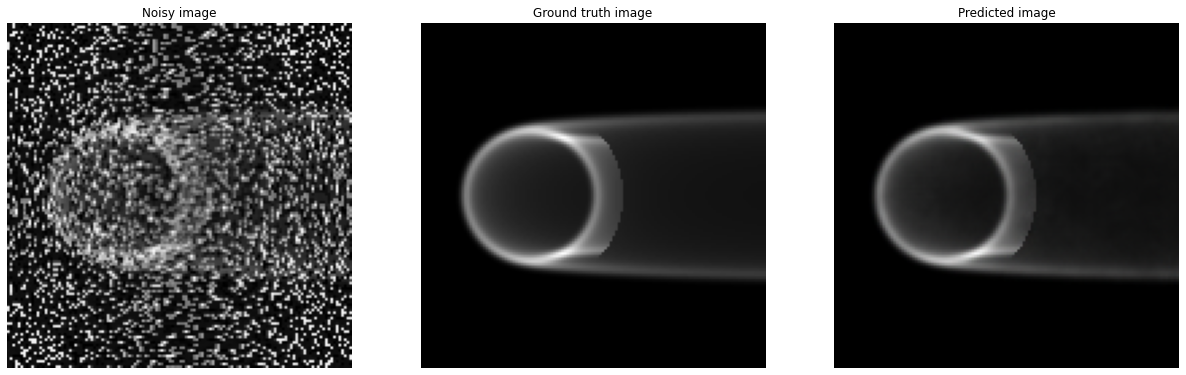

In [ ]:
noisy_test_paths1, gt_test_paths1 = get_images_paths("../g40_p40_s40")

noisy_test_images1 = get_images_in_mem(noisy_test_paths1)
gt_test_images1 = get_images_in_mem(gt_test_paths1)

print(noisy_test_images1.shape)
print(gt_test_images1.shape)

visualize_predictions(model1, noisy_test_images1, gt_test_images1, 1)

from skimage.metrics import peak_signal_noise_ratio

predicted_images = inference_batch_images(model1, noisy_test_images1)
psnr_original_mean = 0
psnr_prediction_mean = 0

for gt_img, noisy_img, predicted_img in zip(gt_test_images1, noisy_test_images1, predicted_images):
    psnr_original_mean += peak_signal_noise_ratio(gt_img, noisy_img)
    psnr_prediction_mean += peak_signal_noise_ratio(gt_img, predicted_img)

psnr_original_mean/=gt_test_images1.shape[0]
psnr_prediction_mean/=gt_test_images1.shape[0]
print("Original average gt-noisy PSNR ->", psnr_original_mean)
print("Predicted average gt-predicted PSNR ->", psnr_prediction_mean)

from skimage.metrics import structural_similarity as ssim

predicted_images = inference_batch_images(model1, noisy_test_images1)
ssim_original_mean = 0
ssim_prediction_mean = 0

for gt_img, noisy_img, predicted_img in zip(gt_test_images1, noisy_test_images1, predicted_images):
    ssim_original_mean += ssim(gt_img, noisy_img, multichannel=True, data_range=noisy_img.max() - noisy_img.min())
    ssim_prediction_mean += ssim(gt_img, predicted_img, multichannel=True, data_range=predicted_img.max() - predicted_img.min())

ssim_original_mean/=gt_test_images1.shape[0]
ssim_prediction_mean/=gt_test_images1.shape[0]
print("Original average gt-noisy SSIM ->", ssim_original_mean)
print("Predicted average gt-predicted SSIM ->", ssim_prediction_mean)


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

(10, 128, 128, 3)
(10, 128, 128, 3)
Original average gt-noisy PSNR -> 29.16757517337636
Predicted average gt-predicted PSNR -> 56.01950502817091
Original average gt-noisy SSIM -> 0.5048314502573271
Predicted average gt-predicted SSIM -> 0.9991398444712812


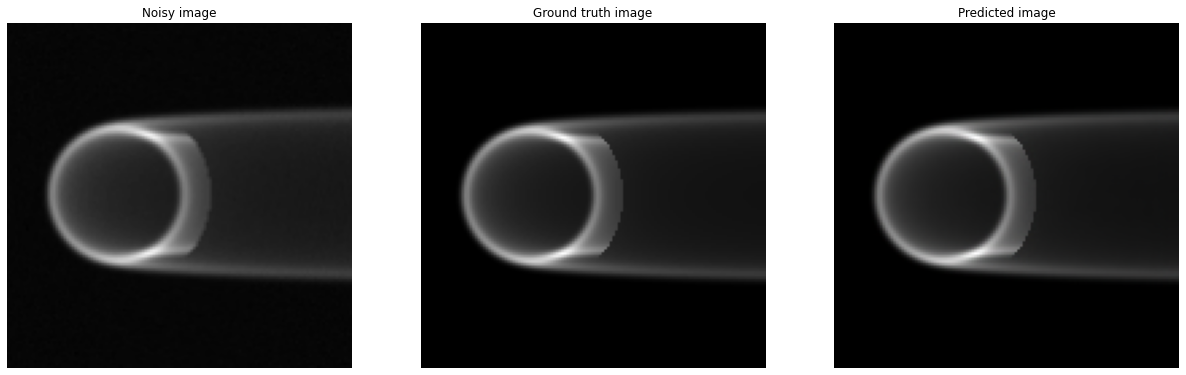

In [ ]:
noisy_test_paths1, gt_test_paths1 = get_images_paths("../p40")

noisy_test_images1 = get_images_in_mem(noisy_test_paths1)
gt_test_images1 = get_images_in_mem(gt_test_paths1)

print(noisy_test_images1.shape)
print(gt_test_images1.shape)

visualize_predictions(model1, noisy_test_images1, gt_test_images1, 1)

from skimage.metrics import peak_signal_noise_ratio

predicted_images = inference_batch_images(model1, noisy_test_images1)
psnr_original_mean = 0
psnr_prediction_mean = 0

for gt_img, noisy_img, predicted_img in zip(gt_test_images1, noisy_test_images1, predicted_images):
    psnr_original_mean += peak_signal_noise_ratio(gt_img, noisy_img)
    psnr_prediction_mean += peak_signal_noise_ratio(gt_img, predicted_img)

psnr_original_mean/=gt_test_images1.shape[0]
psnr_prediction_mean/=gt_test_images1.shape[0]
print("Original average gt-noisy PSNR ->", psnr_original_mean)
print("Predicted average gt-predicted PSNR ->", psnr_prediction_mean)

from skimage.metrics import structural_similarity as ssim

predicted_images = inference_batch_images(model1, noisy_test_images1)
ssim_original_mean = 0
ssim_prediction_mean = 0

for gt_img, noisy_img, predicted_img in zip(gt_test_images1, noisy_test_images1, predicted_images):
    ssim_original_mean += ssim(gt_img, noisy_img, multichannel=True, data_range=noisy_img.max() - noisy_img.min())
    ssim_prediction_mean += ssim(gt_img, predicted_img, multichannel=True, data_range=predicted_img.max() - predicted_img.min())

ssim_original_mean/=gt_test_images1.shape[0]
ssim_prediction_mean/=gt_test_images1.shape[0]
print("Original average gt-noisy SSIM ->", ssim_original_mean)
print("Predicted average gt-predicted SSIM ->", ssim_prediction_mean)


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

(10, 128, 128, 3)
(10, 128, 128, 3)
Original average gt-noisy PSNR -> 9.400364353105171
Predicted average gt-predicted PSNR -> 43.40977431653944
Original average gt-noisy SSIM -> 0.05374584010741479
Predicted average gt-predicted SSIM -> 0.9926692183735362


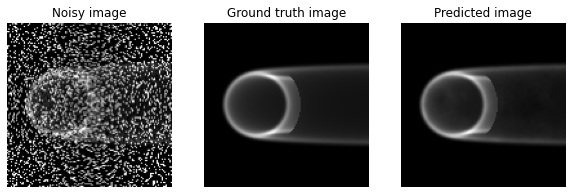

In [ ]:
noisy_test_paths1, gt_test_paths1 = get_images_paths("../s40")

noisy_test_images1 = get_images_in_mem(noisy_test_paths1)
gt_test_images1 = get_images_in_mem(gt_test_paths1)

print(noisy_test_images1.shape)
print(gt_test_images1.shape)

visualize_predictions(model1, noisy_test_images1, gt_test_images1, 1)

from skimage.metrics import peak_signal_noise_ratio

predicted_images = inference_batch_images(model1, noisy_test_images1)
psnr_original_mean = 0
psnr_prediction_mean = 0

for gt_img, noisy_img, predicted_img in zip(gt_test_images1, noisy_test_images1, predicted_images):
    psnr_original_mean += peak_signal_noise_ratio(gt_img, noisy_img)
    psnr_prediction_mean += peak_signal_noise_ratio(gt_img, predicted_img)

psnr_original_mean/=gt_test_images1.shape[0]
psnr_prediction_mean/=gt_test_images1.shape[0]
print("Original average gt-noisy PSNR ->", psnr_original_mean)
print("Predicted average gt-predicted PSNR ->", psnr_prediction_mean)

from skimage.metrics import structural_similarity as ssim

predicted_images = inference_batch_images(model1, noisy_test_images1)
ssim_original_mean = 0
ssim_prediction_mean = 0

for gt_img, noisy_img, predicted_img in zip(gt_test_images1, noisy_test_images1, predicted_images):
    ssim_original_mean += ssim(gt_img, noisy_img, multichannel=True, data_range=noisy_img.max() - noisy_img.min())
    ssim_prediction_mean += ssim(gt_img, predicted_img, multichannel=True, data_range=predicted_img.max() - predicted_img.min())

ssim_original_mean/=gt_test_images1.shape[0]
ssim_prediction_mean/=gt_test_images1.shape[0]
print("Original average gt-noisy SSIM ->", ssim_original_mean)
print("Predicted average gt-predicted SSIM ->", ssim_prediction_mean)


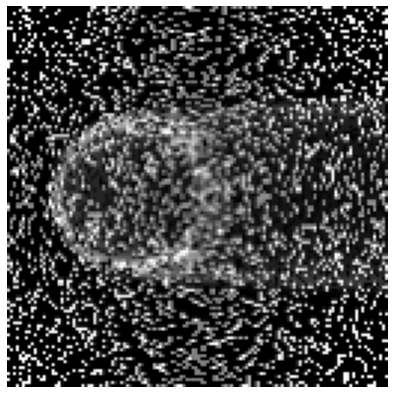

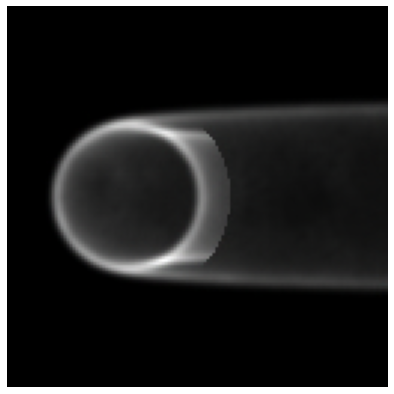

In [ ]:
img_path = "../s40/s40_8.png"

img = cv2.imread(img_path)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
img = cv2.resize(img, (128, 128))

predicted_image = inference_single_image(model1, img)
predicted_image/=255

f, axarr = plt.subplots(1,1, figsize=(7,7))
axarr.imshow(img)
axarr.set_axis_off()
plt.savefig('s40_noisy.png', bbox_inches='tight',pad_inches=0,dpi=100)

f, axarr1 = plt.subplots(1,1, figsize=(7,7))
axarr1.imshow(predicted_image)
axarr1.set_axis_off()
plt.savefig('s40_pred.png', bbox_inches='tight',pad_inches=0,dpi=100)

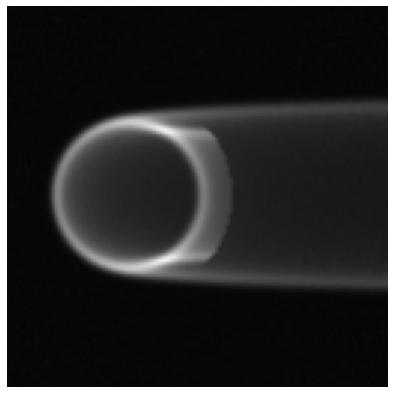

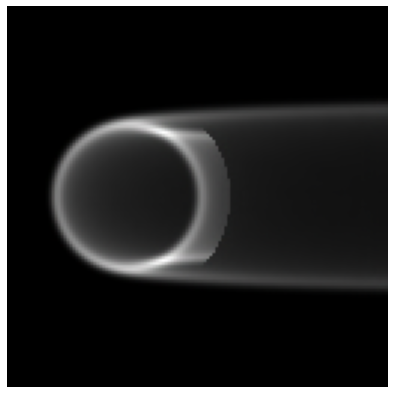

In [ ]:
img_path = "../p40/p40_8.png"

img = cv2.imread(img_path)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
img = cv2.resize(img, (128, 128))

predicted_image = inference_single_image(model1, img)
predicted_image/=255

f, axarr = plt.subplots(1,1, figsize=(7,7))
axarr.imshow(img)
axarr.set_axis_off()
plt.savefig('p40_noisy.png', bbox_inches='tight',pad_inches=0,dpi=100)

f, axarr1 = plt.subplots(1,1, figsize=(7,7))
axarr1.imshow(predicted_image)
axarr1.set_axis_off()
plt.savefig('p40_pred.png', bbox_inches='tight',pad_inches=0,dpi=100)

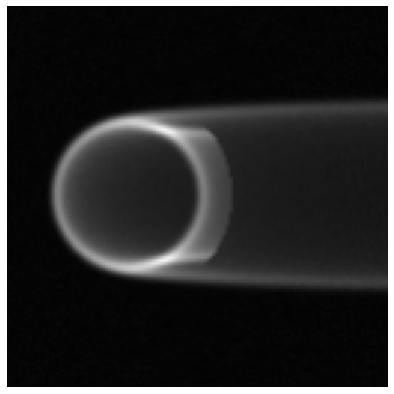

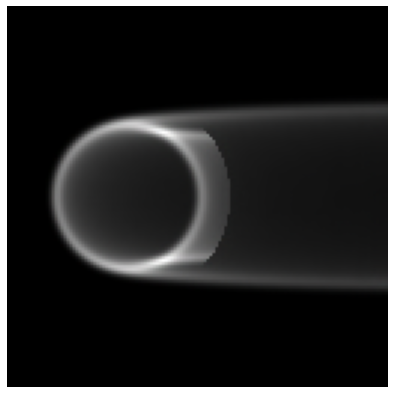

In [ ]:
img_path = "../g40/g40_8.png"

img = cv2.imread(img_path)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
img = cv2.resize(img, (128, 128))

predicted_image = inference_single_image(model1, img)
predicted_image/=255

f, axarr = plt.subplots(1,1, figsize=(7,7))
axarr.imshow(img)
axarr.set_axis_off()
plt.savefig('g40_noisy.png', bbox_inches='tight',pad_inches=0,dpi=100)

f, axarr1 = plt.subplots(1,1, figsize=(7,7))
axarr1.imshow(predicted_image)
axarr1.set_axis_off()
plt.savefig('g40_pred.png', bbox_inches='tight',pad_inches=0,dpi=100)